# Swin Transformer model on CheXpert
This notebook is similiar to the code I have in the [other modeling notebook](https://github.com/kulsoom-abdullah/chexpert_multiclass_multilabel/blob/main/rendered_notebooks/modeling-metadata.html) that uses a CNN architecture with the main difference being that I am using a Transformer architecture.

The goal was for me to use the popular ViT Swin Transformer model on the CheXpert dataset and see if I could beat the results I got with CNN.

I used the [timm](https://rwightman.github.io/pytorch-image-models/) Python library for the Swin Transformer model trained on ImageNet-1k at resolution 224x224. I then unfreeze all of the trainable parameters and trained on the CheXpert multi classification and multi label task.

You can learn more about Swin in the paper [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows by Liu et al.](https://arxiv.org/abs/2103.14030).

TL DR - I got almost the same results as I did with CNN. For more details on the training and results, please see the markdown document



Can have another document to show the training w/neptune plots
Then the final accuracy and ROC plots Recall, F1 of the labels and classes.
Publish on Github
put a line in the read me about this notebook being added.


In [ ]:
import torch
import numpy as np
DEBUG = False # reduce train size for testing purposes when this is set to True
NEPTUNE_TRACK = True #If true, start a neptune session

import neptune
from tqdm import tqdm #to check progress of training

if NEPTUNE_TRACK:
    NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDEyNzFiOTQtNzY0MC00NmY2LThiNTQtNzczODFhMjc0NzUzIn0='
    neptune.init(api_token=NEPTUNE_API_TOKEN, project_qualified_name='kulsoom/CheXpert')

In [4]:
import pandas as pd

#created in the EDA notebook
train_df = pd.read_pickle('train_df.pkl')
valid_df = pd.read_pickle('valid_df.pkl')
disease_counts_df =  pd.read_pickle('disease_count.pkl')


train_df.head(5)

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         0.0           0.0   
1         Frontal    AP         0.0                         0.0          -1.0   
2         Frontal    AP         0.0                         0.0           0.0   
3         Lateral   NaN         0.0                         0.0           0.0   
4         Frontal    AP         0.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           0.0          0.0    0.0            0.0        0.0          0.0   
1           1.0          0.0   -1.0           -1.0        0.0         -1.0   
2           1.0          0.0    0.0           -1.0        0.0          0.0   
3           1.0          0.0    0.0           -1.0        0.0          0.0   
4           0.0          0.0    1.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  \
0           0.0               0.0            0.0       0.0              1.0   
1           0.0              -1.0            0.0       1.0              0.0   
2           0.0               0.0            0.0       1.0              0.0   
3           0.0               0.0            0.0       1.0              0.0   
4           0.0               0.0            0.0       0.0              0.0   

   Number of Diseases  
0                   0  
1                   2  
2                   2  
3                   2  
4                   1

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# create labels, which will be a dictionary with image path: list of labels
filters = (train_df['Frontal/Lateral'] == 'Frontal') & (train_df['AP/PA'] == 'AP')

disease_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']

if DEBUG:
    train_df = train_df.sample(frac=0.01, random_state=123)
#replace -1 with 2 for the uncertain class
train_df[disease_cols] = train_df[disease_cols].replace([-1.0],2.0)
train_labels = train_df[filters][disease_cols].values
train_paths = train_df[filters].Path.values
train_ages = train_df[filters].Age.values
train_genders = train_df[filters].Sex.values

valid_df[disease_cols] = valid_df[disease_cols].replace([-1.0],2.0)
valid_labels = valid_df[filters][disease_cols].values
valid_paths = valid_df[filters].Path.values
valid_ages = valid_df[filters].Age.values
valid_genders = valid_df[filters].Sex.values

root_path = ''
# root_path = ''
train_paths =  [root_path + p for p in train_paths]
valid_paths =  [root_path + p for p in valid_paths]

age_mean = np.mean(train_ages)  #60
age_std = np.std(train_ages)

<ipython-input-5-846a698001f9>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_labels = valid_df[filters][disease_cols].values
<ipython-input-5-846a698001f9>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_paths = valid_df[filters].Path.values
<ipython-input-5-846a698001f9>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_ages = valid_df[filters].Age.values
<ipython-input-5-846a698001f9>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_genders = valid_df[filters].Sex.values


In [6]:

I = np.eye(3) #for 3 class coding, positive, negative uncertain 

gender_map = {'Female': 0, 'Male': 1, 'Unknown': 2}
gender_tensor = torch.zeros(len(gender_map))

class CheXpertDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, ages, genders, transforms):
        '''
        
        labels: a list of lists with values 0, 1 or 2 for each of the 13 classes
        image_paths: list of the file paths to the image
        transforms: transoforms to use for the images for input into model
         
        '''
        self.labels = labels
        self.image_paths = image_paths
        self.age = ages
        self.gender = genders
        self.transform = transforms

        
    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
 
        # read image
        #use below to change the image to color w/out the repeat transform
        image = Image.open(img_path).convert('RGB')
 

        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        vec = np.array(label, dtype=int)
#         single vector to the one-hot encoding (3xlen(labels))
        out = I[vec].ravel()

        label = torch.from_numpy(out)
        
        #returning tuple because LRFinder expects one input. 
        #this will be unpacked in the model forward function
        return image, label
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_paths)    

In [7]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
# device

In [9]:
import timm

class ViT(nn.Module):
    def __init__(self, out_dim=39, num_channels=1):
        super().__init__()
        self.preloaded = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=out_dim)

    def forward(self, x):
        out = self.preloaded(x)
        return out

In [10]:
# from https://amaarora.github.io/2020/06/29/FocalLoss.html
# the code assumes binary classification.  Since I am doing multilabel - multiclass, need to flatten BCE_loss

class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    # mean is the boolean to decide between returning the mean vs the whole vector of loss
    def forward(self, inputs, targets, mean=True):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_loss = BCE_loss.view(-1).contiguous()
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1)).contiguous()
        pt = torch.exp(-BCE_loss)

        F_loss = at*(1-pt)**self.gamma * BCE_loss
        if mean:
            return F_loss.mean()
        else:
            return F_loss

In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, multilabel_confusion_matrix, \
accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore", message="No negative samples in y_true, false positive value should be meaningless")
warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
#suppressing 
# This means that all the values in y_true are zeros or all ones, which means there is no positive class or neg class records in the given dataset.


classes = {0: 'Negative', 1: 'Positive', 2: 'Uncertain'}
def calc_val_metrics(gt, pred):
    conf_mat_dict={}
    fpr = {} #these will be dictionary of dictionaries for each disease to keep values for each class
    tpr = {}
    roc_auc = {}
    precision = {}
    recall = {}
    f1 = {}
    accuracy = {}
    
    gt = np.array(gt)
    pred = np.array(pred)
    # for d,disease in enumerate(disease_cols):
    for i,disease in zip(range(0,39,3), disease_cols): #travese every 3 digits
        
        y_true_label = gt[:, i:i+3] 
        y_pred_label = pred[:, i:i+3]
        conf_mat_dict[disease] = multilabel_confusion_matrix(y_pred=y_pred_label.argmax(axis=1), 
                                                             y_true=y_true_label.argmax(axis=1), labels=[0,1,2])
  
        fpr[disease] = {}
        tpr[disease] = {}
        roc_auc[disease] = {}
        precision[disease] = {}
        recall[disease] = {}
        f1[disease] = {}
        for col, label in enumerate(['Negative', 'Positive', 'Uncertain']):
            fpr[disease][label], tpr[disease][label], _ = roc_curve(y_true_label[:,col], (y_pred_label[:,col] >= 0.5).astype(float))
            
            try: #for when not perfect. hence auc is 1 
                roc_auc[disease][label] = roc_auc_score(y_true=y_true_label[:,col], y_score=y_pred_label[:,col])
            except ValueError:
                roc_auc[disease][label] = 1
        accuracy[disease] = accuracy_score(y_true_label.argmax(axis=1), y_pred_label.argmax(axis=1))
    lw = 4
    figsize = (20, 25)
    cols = 3
    rows = len(disease_cols) // cols + 1
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    fig,ax = plt.subplots(rows, cols, figsize=figsize)
    axes = ax.flatten()
    
    for d_ix,disease in enumerate(disease_cols):
        for i, label in enumerate(['Negative', 'Positive', 'Uncertain']):
            if label in fpr[disease]:
                axes[d_ix].plot(fpr[disease][label], tpr[disease][label], color=colors[i], lw=lw,
         label=f'Class {classes[i]} (area = {roc_auc[disease][label]:0.2f})')
        axes[d_ix].plot([0, 1], [0, 1], 'k--', lw=lw)
        axes[d_ix].set_xlim([0.0, 1.0])
        axes[d_ix].set_ylim([0.0, 1.05])
        axes[d_ix].set_xlabel('False Positive Rate')
        axes[d_ix].set_ylabel('True Positive Rate')
        axes[d_ix].set_title(f'{disease} ROC Curve')
        axes[d_ix].legend(loc="lower right")
        
    return conf_mat_dict,fpr,tpr,roc_auc,accuracy, precision, recall, f1

In [22]:
# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 4}

max_epochs = 100

train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5330], std=[0.0349]) ])

training_set = CheXpertDataset(train_paths, train_labels, train_ages, train_genders, train_transforms)
training_generator = torch.utils.data.DataLoader(training_set, **params)

#for now train and valid transforms can be the same
valid_transforms = train_transforms
validation_set = CheXpertDataset(valid_paths, valid_labels, valid_ages, valid_genders, valid_transforms)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [23]:
# to load model weights from a last checkpoint
MODEL_PATH = 'checkpoint_meta4.pt'
model = ViT()
model.load_state_dict(torch.load(MODEL_PATH))

model.to(device)

# unfreeze it all to fine tune
    
for name, param in model.named_parameters():
    param.requires_grad == True
        

In [14]:
# sanity check
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)#, param.data)

preloaded.patch_embed.proj.weight
preloaded.patch_embed.proj.bias
preloaded.patch_embed.norm.weight
preloaded.patch_embed.norm.bias
preloaded.layers.0.blocks.0.norm1.weight
preloaded.layers.0.blocks.0.norm1.bias
preloaded.layers.0.blocks.0.attn.relative_position_bias_table
preloaded.layers.0.blocks.0.attn.qkv.weight
preloaded.layers.0.blocks.0.attn.qkv.bias
preloaded.layers.0.blocks.0.attn.proj.weight
preloaded.layers.0.blocks.0.attn.proj.bias
preloaded.layers.0.blocks.0.norm2.weight
preloaded.layers.0.blocks.0.norm2.bias
preloaded.layers.0.blocks.0.mlp.fc1.weight
preloaded.layers.0.blocks.0.mlp.fc1.bias
preloaded.layers.0.blocks.0.mlp.fc2.weight
preloaded.layers.0.blocks.0.mlp.fc2.bias
preloaded.layers.0.blocks.1.norm1.weight
preloaded.layers.0.blocks.1.norm1.bias
preloaded.layers.0.blocks.1.attn.relative_position_bias_table
preloaded.layers.0.blocks.1.attn.qkv.weight
preloaded.layers.0.blocks.1.attn.qkv.bias
preloaded.layers.0.blocks.1.attn.proj.weight
preloaded.layers.0.blocks.1.att

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-05


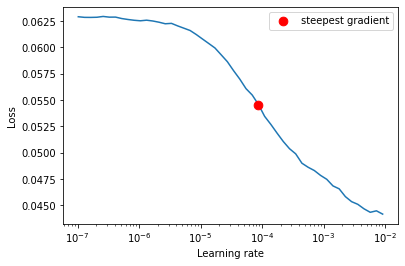

In [24]:
from torch_lr_finder import LRFinder
learning_rate = 1e-8
betas = (0.9, 0.999)
weight_decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             betas=betas, weight_decay = weight_decay)

loss_fn = WeightedFocalLoss()
lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
lr_finder.range_test(training_generator, end_lr=100, num_iter=100)#, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() #

In [25]:
def save_checkpoint(val_loss, val_loss_min, model, path, verbose=True):
    '''Saves model when validation loss decrease.'''
    if verbose:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), path)

In [26]:
#suggested by LRFinder, fast.ai way
learning_rate = 8.70E-05
betas = (0.9, 0.999)
weight_decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             betas=betas, weight_decay = weight_decay)
loss_fn = WeightedFocalLoss()
         
params["train_transforms"] = str(train_transforms)
params["val_transforms"] = str(valid_transforms)
params['lr'] = learning_rate
params.update({ 'betas':betas,'epochs':max_epochs,'weight_decay':weight_decay})
                             

In [27]:
#pass the dictionary of parameters to neptune for experiment tracking
if NEPTUNE_TRACK:
    neptune.create_experiment('swin_base_patch4_window7_wloss_finetune',params=params)

https://ui.neptune.ai/kulsoom/CheXpert/e/CHEX-56


Epoch 0/99


  0%|          | 2/10100 [00:00<1:06:42,  2.52it/s]

Batch Loss 1/10100: 0.060


 15%|█▍        | 1502/10100 [03:26<21:30,  6.66it/s]

Batch Loss 1501/10100: 0.031


 30%|██▉       | 3002/10100 [06:51<16:22,  7.22it/s]

Batch Loss 3001/10100: 0.033


 45%|████▍     | 4502/10100 [10:17<12:49,  7.27it/s]

Batch Loss 4501/10100: 0.035


 59%|█████▉    | 6002/10100 [13:43<09:13,  7.40it/s]

Batch Loss 6001/10100: 0.030


 74%|███████▍  | 7502/10100 [17:09<05:50,  7.41it/s]

Batch Loss 7501/10100: 0.037


 89%|████████▉ | 9002/10100 [20:36<02:34,  7.09it/s]

Batch Loss 9001/10100: 0.031


100%|██████████| 10100/10100 [23:07<00:00,  7.28it/s]


Train Loss: 0.035
validation batch Loss 1/8: 0.036
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.005185 

Validation loss decreased (inf --> 0.005185).  Saving model ...
Epoch 1/99


  0%|          | 2/10100 [00:00<50:39,  3.32it/s]  

Batch Loss 1/10100: 0.034


 15%|█▍        | 1502/10100 [03:26<19:25,  7.38it/s]

Batch Loss 1501/10100: 0.034


 30%|██▉       | 3002/10100 [06:51<16:00,  7.39it/s]

Batch Loss 3001/10100: 0.032


 45%|████▍     | 4502/10100 [10:16<12:40,  7.36it/s]

Batch Loss 4501/10100: 0.036


 59%|█████▉    | 6002/10100 [13:42<09:15,  7.38it/s]

Batch Loss 6001/10100: 0.040


 74%|███████▍  | 7502/10100 [17:06<05:49,  7.43it/s]

Batch Loss 7501/10100: 0.034


 89%|████████▉ | 9002/10100 [20:30<02:26,  7.49it/s]

Batch Loss 9001/10100: 0.034


100%|██████████| 10100/10100 [23:00<00:00,  7.32it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.032
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.004438 

Validation loss decreased (0.005185 --> 0.004438).  Saving model ...
Epoch 2/99


  0%|          | 2/10100 [00:00<48:26,  3.47it/s]  

Batch Loss 1/10100: 0.033


 15%|█▍        | 1502/10100 [03:23<19:05,  7.51it/s]

Batch Loss 1501/10100: 0.033


 30%|██▉       | 3002/10100 [06:46<16:16,  7.27it/s]

Batch Loss 3001/10100: 0.039


 45%|████▍     | 4502/10100 [10:10<13:50,  6.74it/s]

Batch Loss 4501/10100: 0.041


 59%|█████▉    | 6002/10100 [13:34<09:04,  7.53it/s]

Batch Loss 6001/10100: 0.038


 74%|███████▍  | 7502/10100 [16:57<05:56,  7.28it/s]

Batch Loss 7501/10100: 0.035


 89%|████████▉ | 9002/10100 [20:21<02:42,  6.75it/s]

Batch Loss 9001/10100: 0.036


100%|██████████| 10100/10100 [22:50<00:00,  7.37it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.035
Val Loss: 0.006
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.005751 

Epoch 3/99


  0%|          | 2/10100 [00:00<47:06,  3.57it/s]  

Batch Loss 1/10100: 0.032


 15%|█▍        | 1502/10100 [03:23<19:11,  7.46it/s]

Batch Loss 1501/10100: 0.030


 30%|██▉       | 3002/10100 [06:46<16:15,  7.28it/s]

Batch Loss 3001/10100: 0.033


 45%|████▍     | 4502/10100 [10:10<13:24,  6.96it/s]

Batch Loss 4501/10100: 0.031


 59%|█████▉    | 6002/10100 [13:34<09:08,  7.48it/s]

Batch Loss 6001/10100: 0.036


 74%|███████▍  | 7502/10100 [16:57<05:48,  7.46it/s]

Batch Loss 7501/10100: 0.033


 89%|████████▉ | 9002/10100 [20:20<02:33,  7.13it/s]

Batch Loss 9001/10100: 0.032


100%|██████████| 10100/10100 [22:50<00:00,  7.37it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.034
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.004601 

Epoch 4/99


  0%|          | 2/10100 [00:00<50:15,  3.35it/s]  

Batch Loss 1/10100: 0.034


 15%|█▍        | 1502/10100 [03:24<19:06,  7.50it/s]

Batch Loss 1501/10100: 0.037


 30%|██▉       | 3002/10100 [06:47<15:58,  7.41it/s]

Batch Loss 3001/10100: 0.032


 45%|████▍     | 4502/10100 [10:10<12:34,  7.42it/s]

Batch Loss 4501/10100: 0.033


 59%|█████▉    | 6002/10100 [13:34<10:03,  6.79it/s]

Batch Loss 6001/10100: 0.033


 74%|███████▍  | 7502/10100 [16:58<05:49,  7.44it/s]

Batch Loss 7501/10100: 0.037


100%|██████████| 10100/10100 [22:50<00:00,  7.37it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.028
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.005291 

Epoch 5/99


  0%|          | 2/10100 [00:00<47:10,  3.57it/s]  

Batch Loss 1/10100: 0.038


 15%|█▍        | 1502/10100 [03:23<20:37,  6.95it/s]

Batch Loss 1501/10100: 0.034


 30%|██▉       | 3002/10100 [06:46<16:00,  7.39it/s]

Batch Loss 3001/10100: 0.037


 41%|████      | 4097/10100 [09:15<13:28,  7.43it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 7502/10100 [16:57<05:50,  7.41it/s]

Batch Loss 7501/10100: 0.037


 89%|████████▉ | 9002/10100 [20:21<02:26,  7.48it/s]

Batch Loss 9001/10100: 0.035


100%|██████████| 10100/10100 [22:50<00:00,  7.37it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.034
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.005370 

Epoch 6/99


  0%|          | 2/10100 [00:00<50:16,  3.35it/s]  

Batch Loss 1/10100: 0.037


 15%|█▍        | 1502/10100 [03:24<19:23,  7.39it/s]

Batch Loss 1501/10100: 0.036


 30%|██▉       | 3002/10100 [06:48<16:05,  7.35it/s]

Batch Loss 3001/10100: 0.040


 45%|████▍     | 4502/10100 [10:12<12:41,  7.35it/s]

Batch Loss 4501/10100: 0.035


 59%|█████▉    | 6002/10100 [13:36<09:11,  7.43it/s]

Batch Loss 6001/10100: 0.031


 74%|███████▍  | 7502/10100 [17:01<05:47,  7.48it/s]

Batch Loss 7501/10100: 0.034


 89%|████████▉ | 9002/10100 [20:25<02:27,  7.43it/s]

Batch Loss 9001/10100: 0.036


100%|██████████| 10100/10100 [22:55<00:00,  7.34it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.039
Val Loss: 0.006
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.005724 

Epoch 7/99


  0%|          | 2/10100 [00:00<50:08,  3.36it/s]  

Batch Loss 1/10100: 0.033


 15%|█▍        | 1502/10100 [03:23<19:11,  7.47it/s]

Batch Loss 1501/10100: 0.036


 30%|██▉       | 3002/10100 [06:47<15:55,  7.42it/s]

Batch Loss 3001/10100: 0.031


 45%|████▍     | 4502/10100 [10:11<13:14,  7.05it/s]

Batch Loss 4501/10100: 0.032


 59%|█████▉    | 6002/10100 [13:35<09:09,  7.46it/s]

Batch Loss 6001/10100: 0.035


 74%|███████▍  | 7502/10100 [16:59<05:46,  7.50it/s]

Batch Loss 7501/10100: 0.031


 89%|████████▉ | 9002/10100 [20:24<02:27,  7.44it/s]

Batch Loss 9001/10100: 0.034


100%|██████████| 10100/10100 [22:53<00:00,  7.35it/s]


Train Loss: 0.034
validation batch Loss 1/8: 0.036
Val Loss: 0.007
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.006549 

Epoch 8/99


  0%|          | 2/10100 [00:00<49:28,  3.40it/s]  

Batch Loss 1/10100: 0.036


 15%|█▍        | 1502/10100 [03:24<19:12,  7.46it/s]

Batch Loss 1501/10100: 0.032


 30%|██▉       | 3002/10100 [06:48<16:18,  7.25it/s]

Batch Loss 3001/10100: 0.034


 45%|████▍     | 4502/10100 [10:12<13:22,  6.97it/s]

Batch Loss 4501/10100: 0.028


 59%|█████▉    | 6002/10100 [13:37<09:06,  7.50it/s]

Batch Loss 6001/10100: 0.030


 74%|███████▍  | 7502/10100 [17:01<06:04,  7.12it/s]

Batch Loss 7501/10100: 0.034


 89%|████████▉ | 9002/10100 [20:26<02:27,  7.44it/s]

Batch Loss 9001/10100: 0.031


100%|██████████| 10100/10100 [22:55<00:00,  7.34it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.041
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.004886 

Epoch 9/99


  0%|          | 2/10100 [00:00<48:10,  3.49it/s]  

Batch Loss 1/10100: 0.037


 15%|█▍        | 1502/10100 [03:24<19:06,  7.50it/s]

Batch Loss 1501/10100: 0.028


 30%|██▉       | 3002/10100 [06:48<15:41,  7.54it/s]

Batch Loss 3001/10100: 0.033


 45%|████▍     | 4502/10100 [10:12<12:38,  7.38it/s]

Batch Loss 4501/10100: 0.037


 59%|█████▉    | 6002/10100 [13:36<09:19,  7.32it/s]

Batch Loss 6001/10100: 0.029


 74%|███████▍  | 7502/10100 [17:00<05:45,  7.52it/s]

Batch Loss 7501/10100: 0.033


 89%|████████▉ | 9002/10100 [20:25<02:28,  7.40it/s]

Batch Loss 9001/10100: 0.034


100%|██████████| 10100/10100 [22:54<00:00,  7.35it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.036
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.004093 

Validation loss decreased (0.004438 --> 0.004093).  Saving model ...
Epoch 10/99


  0%|          | 2/10100 [00:00<52:49,  3.19it/s]  

Batch Loss 1/10100: 0.032


 15%|█▍        | 1502/10100 [03:24<19:33,  7.33it/s]

Batch Loss 1501/10100: 0.035


 30%|██▉       | 3002/10100 [06:48<15:56,  7.42it/s]

Batch Loss 3001/10100: 0.039


 45%|████▍     | 4502/10100 [10:13<12:29,  7.47it/s]

Batch Loss 4501/10100: 0.033


 59%|█████▉    | 6002/10100 [13:37<09:20,  7.31it/s]

Batch Loss 6001/10100: 0.032


 74%|███████▍  | 7502/10100 [17:01<05:54,  7.34it/s]

Batch Loss 7501/10100: 0.037


 89%|████████▉ | 9002/10100 [20:25<02:35,  7.05it/s]

Batch Loss 9001/10100: 0.031


100%|██████████| 10100/10100 [22:55<00:00,  7.34it/s]


Train Loss: 0.034
validation batch Loss 1/8: 0.032
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.004455 

Epoch 11/99


  0%|          | 2/10100 [00:00<49:40,  3.39it/s]  

Batch Loss 1/10100: 0.038


 15%|█▍        | 1502/10100 [03:24<19:50,  7.22it/s]

Batch Loss 1501/10100: 0.037


 30%|██▉       | 3002/10100 [06:48<15:44,  7.51it/s]

Batch Loss 3001/10100: 0.036


 45%|████▍     | 4502/10100 [10:12<12:34,  7.42it/s]

Batch Loss 4501/10100: 0.037


 59%|█████▉    | 6002/10100 [13:37<09:10,  7.44it/s]

Batch Loss 6001/10100: 0.038


 74%|███████▍  | 7502/10100 [17:01<05:57,  7.27it/s]

Batch Loss 7501/10100: 0.033


 89%|████████▉ | 9002/10100 [20:26<02:29,  7.35it/s]

Batch Loss 9001/10100: 0.036


100%|██████████| 10100/10100 [22:55<00:00,  7.34it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.031
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.005379 

Epoch 12/99


  0%|          | 2/10100 [00:00<49:31,  3.40it/s]  

Batch Loss 1/10100: 0.039


 15%|█▍        | 1502/10100 [03:24<19:38,  7.30it/s]

Batch Loss 1501/10100: 0.032


 30%|██▉       | 3002/10100 [06:48<16:07,  7.34it/s]

Batch Loss 3001/10100: 0.036


 45%|████▍     | 4502/10100 [10:12<12:33,  7.43it/s]

Batch Loss 4501/10100: 0.033


 59%|█████▉    | 6002/10100 [13:37<09:03,  7.54it/s]

Batch Loss 6001/10100: 0.028


 74%|███████▍  | 7502/10100 [17:01<05:50,  7.41it/s]

Batch Loss 7501/10100: 0.037


 89%|████████▉ | 9002/10100 [20:25<02:26,  7.49it/s]

Batch Loss 9001/10100: 0.033


 15%|█▍        | 1502/10100 [03:24<19:17,  7.43it/s]

Batch Loss 1501/10100: 0.034


 30%|██▉       | 3002/10100 [06:48<16:02,  7.38it/s]

Batch Loss 3001/10100: 0.037


 31%|███       | 3085/10100 [06:59<15:45,  7.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 10100/10100 [22:54<00:00,  7.35it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.034
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.005329 

Epoch 14/99


  0%|          | 2/10100 [00:00<49:58,  3.37it/s]  

Batch Loss 1/10100: 0.035


 15%|█▍        | 1502/10100 [03:24<19:11,  7.47it/s]

Batch Loss 1501/10100: 0.031


 30%|██▉       | 3002/10100 [06:48<16:01,  7.38it/s]

Batch Loss 3001/10100: 0.034


 45%|████▍     | 4502/10100 [10:12<13:25,  6.95it/s]

Batch Loss 4501/10100: 0.034


 59%|█████▉    | 6002/10100 [13:37<09:08,  7.48it/s]

Batch Loss 6001/10100: 0.034


 74%|███████▍  | 7502/10100 [17:01<05:52,  7.37it/s]

Batch Loss 7501/10100: 0.040


 89%|████████▉ | 9002/10100 [20:25<02:27,  7.46it/s]

Batch Loss 9001/10100: 0.037


100%|██████████| 10100/10100 [22:55<00:00,  7.34it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.035
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.004868 

Epoch 15/99


  0%|          | 2/10100 [00:00<56:19,  2.99it/s]  

Batch Loss 1/10100: 0.030


 15%|█▍        | 1502/10100 [03:24<19:20,  7.41it/s]

Batch Loss 1501/10100: 0.033


 30%|██▉       | 3002/10100 [06:49<15:56,  7.42it/s]

Batch Loss 3001/10100: 0.035


 45%|████▍     | 4502/10100 [10:13<12:27,  7.49it/s]

Batch Loss 4501/10100: 0.037


 59%|█████▉    | 6002/10100 [13:38<09:09,  7.45it/s]

Batch Loss 6001/10100: 0.034


 74%|███████▍  | 7502/10100 [17:02<06:23,  6.77it/s]

Batch Loss 7501/10100: 0.037


 89%|████████▉ | 9002/10100 [20:26<02:31,  7.25it/s]

Batch Loss 9001/10100: 0.032


100%|██████████| 10100/10100 [22:55<00:00,  7.34it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.037
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.005059 

Epoch 16/99


  0%|          | 2/10100 [00:00<50:11,  3.35it/s]  

Batch Loss 1/10100: 0.036


 15%|█▍        | 1502/10100 [03:24<19:25,  7.38it/s]

Batch Loss 1501/10100: 0.034


 30%|██▉       | 3002/10100 [06:48<16:00,  7.39it/s]

Batch Loss 3001/10100: 0.037


 45%|████▍     | 4502/10100 [10:12<12:28,  7.48it/s]

Batch Loss 4501/10100: 0.032


 59%|█████▉    | 6002/10100 [13:36<09:16,  7.36it/s]

Batch Loss 6001/10100: 0.033


 74%|███████▍  | 7502/10100 [17:00<05:49,  7.43it/s]

Batch Loss 7501/10100: 0.038


 89%|████████▉ | 9002/10100 [20:25<02:27,  7.44it/s]

Batch Loss 9001/10100: 0.034


100%|██████████| 10100/10100 [22:54<00:00,  7.35it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.030
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.004774 

Epoch 17/99


  0%|          | 2/10100 [00:00<56:17,  2.99it/s]  

Batch Loss 1/10100: 0.029


 15%|█▍        | 1502/10100 [03:24<19:15,  7.44it/s]

Batch Loss 1501/10100: 0.036


 30%|██▉       | 3002/10100 [06:48<15:49,  7.47it/s]

Batch Loss 3001/10100: 0.033


 45%|████▍     | 4502/10100 [10:12<12:52,  7.24it/s]

Batch Loss 4501/10100: 0.037


 59%|█████▉    | 6002/10100 [13:36<09:21,  7.30it/s]

Batch Loss 6001/10100: 0.033


 74%|███████▍  | 7502/10100 [17:00<05:45,  7.52it/s]

Batch Loss 7501/10100: 0.034


 89%|████████▉ | 9002/10100 [20:24<02:29,  7.32it/s]

Batch Loss 9001/10100: 0.036


100%|██████████| 10100/10100 [22:53<00:00,  7.35it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.038
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.005192 

Epoch 18/99


  0%|          | 2/10100 [00:00<49:43,  3.38it/s]  

Batch Loss 1/10100: 0.036


 15%|█▍        | 1502/10100 [03:24<19:13,  7.46it/s]

Batch Loss 1501/10100: 0.038


 30%|██▉       | 3002/10100 [06:48<15:55,  7.43it/s]

Batch Loss 3001/10100: 0.034


 45%|████▍     | 4502/10100 [10:12<12:52,  7.25it/s]

Batch Loss 4501/10100: 0.037


 59%|█████▉    | 6002/10100 [13:35<09:15,  7.38it/s]

Batch Loss 6001/10100: 0.028


 74%|███████▍  | 7502/10100 [17:00<05:53,  7.35it/s]

Batch Loss 7501/10100: 0.032


100%|██████████| 10100/10100 [22:54<00:00,  7.35it/s]

Train Loss: 0.034


validation batch Loss 1/8: 0.033
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.004982 

Epoch 19/99


  0%|          | 2/10100 [00:00<47:25,  3.55it/s]  

Batch Loss 1/10100: 0.044


 15%|█▍        | 1502/10100 [03:24<19:38,  7.30it/s]

Batch Loss 1501/10100: 0.029


 21%|██        | 2074/10100 [04:42<18:12,  7.34it/s]


KeyboardInterrupt: 

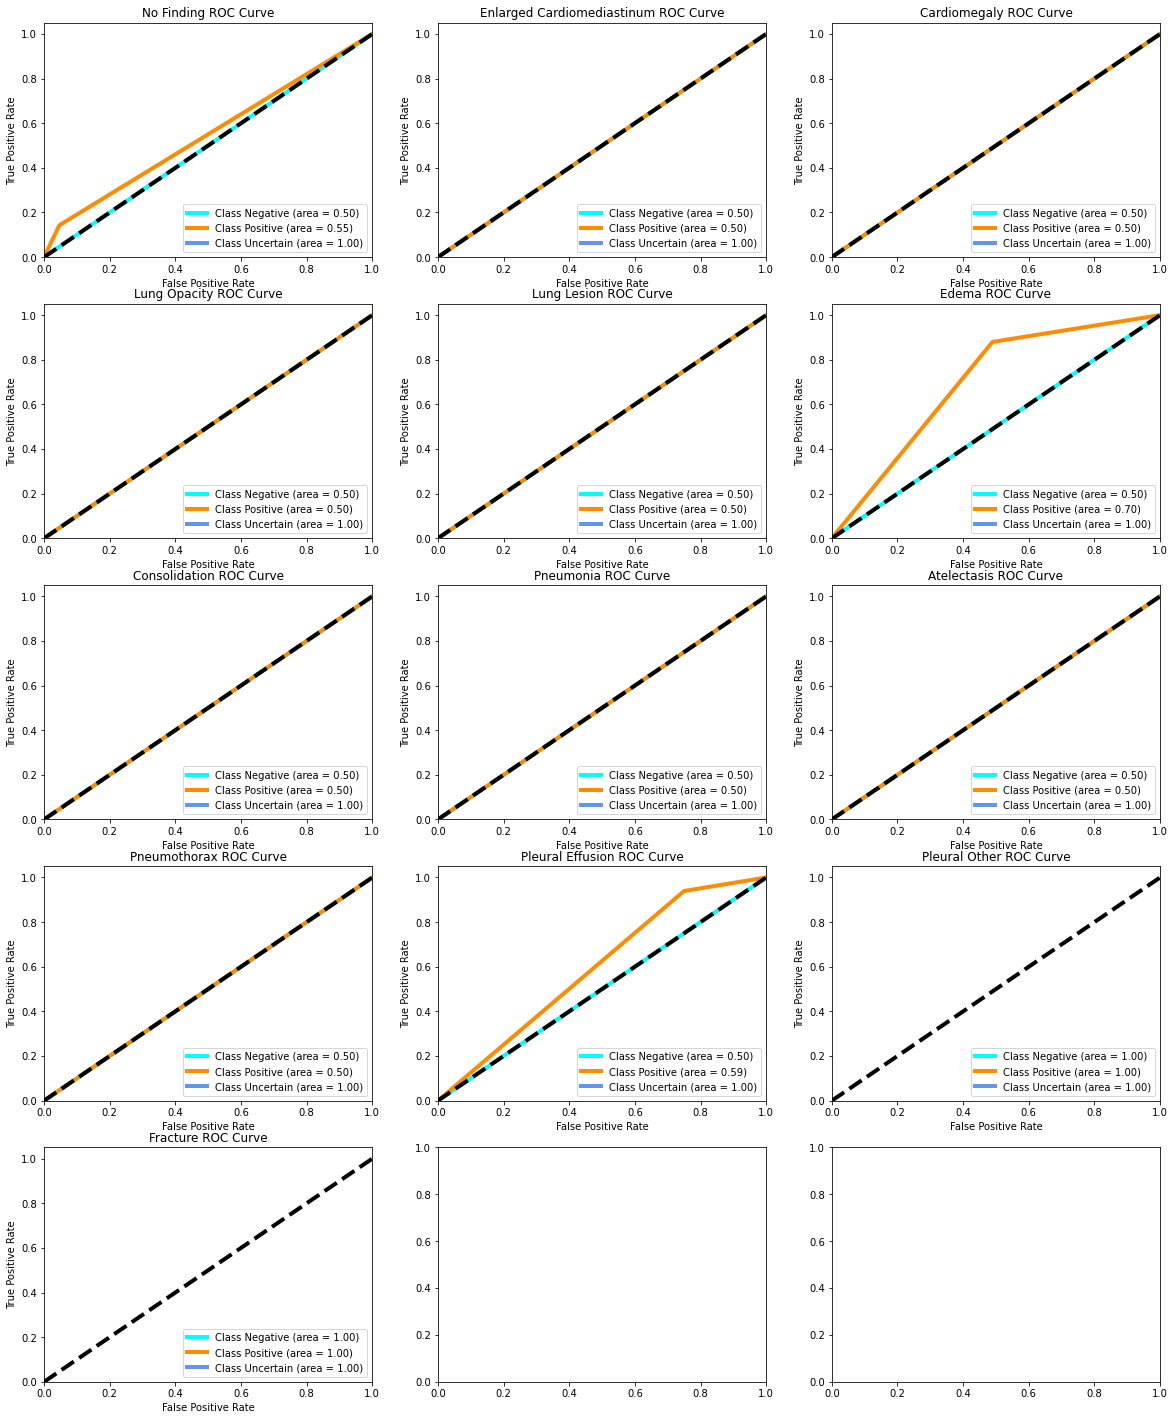

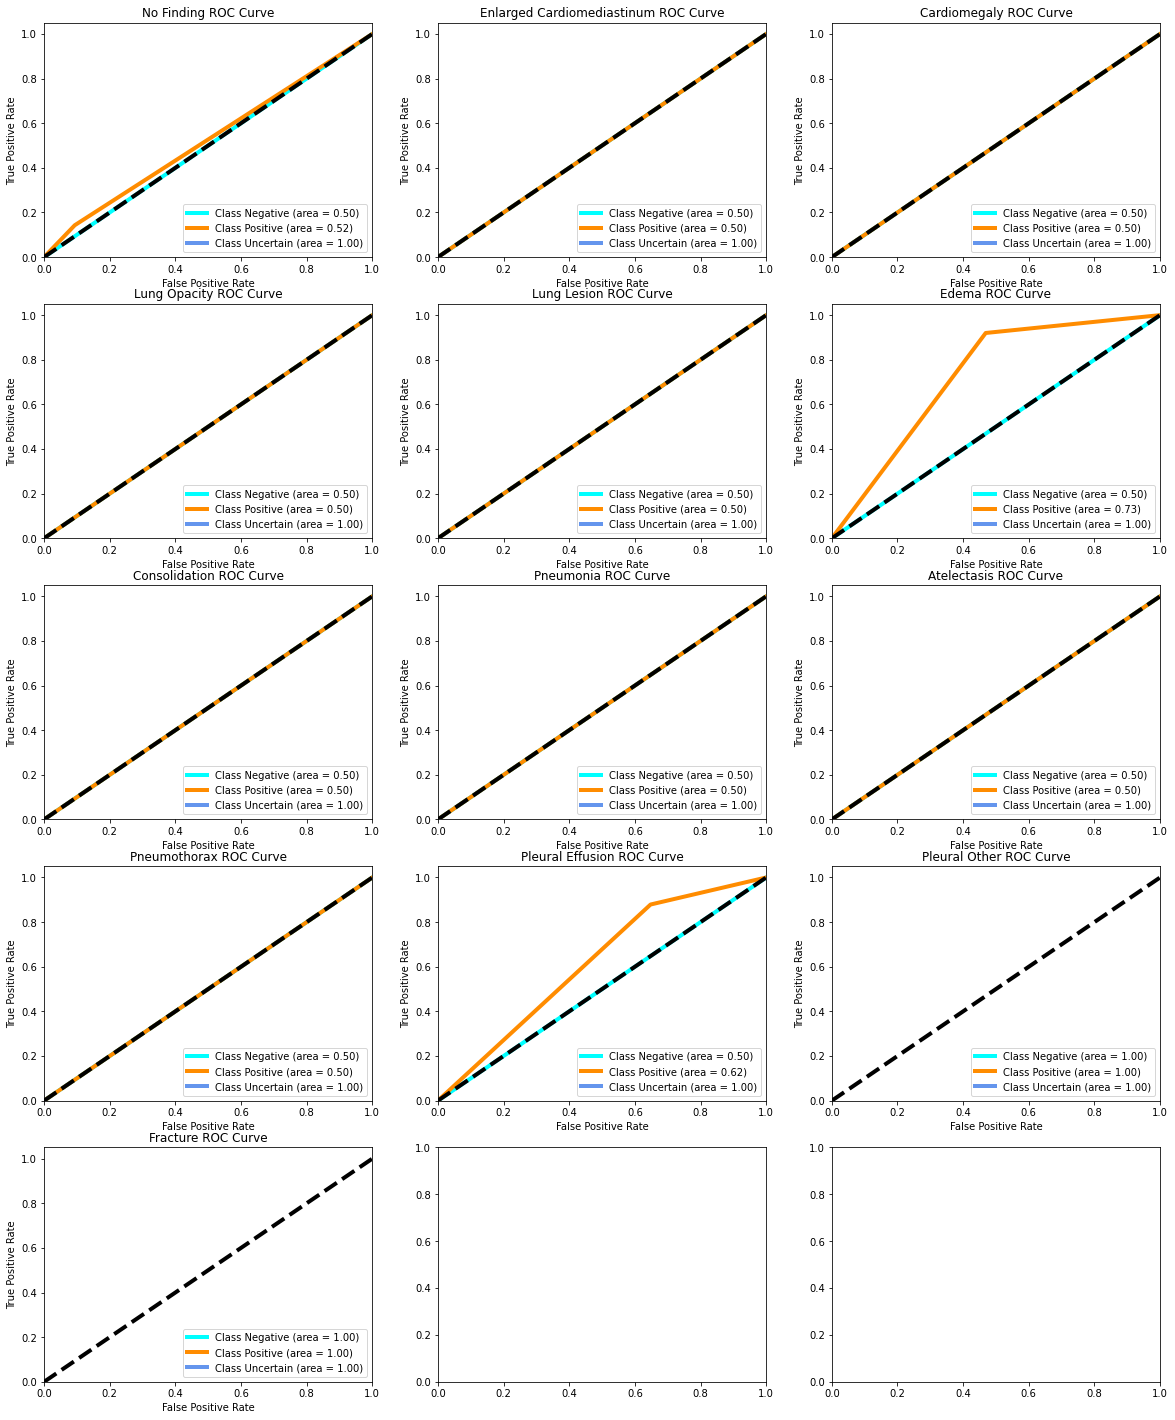

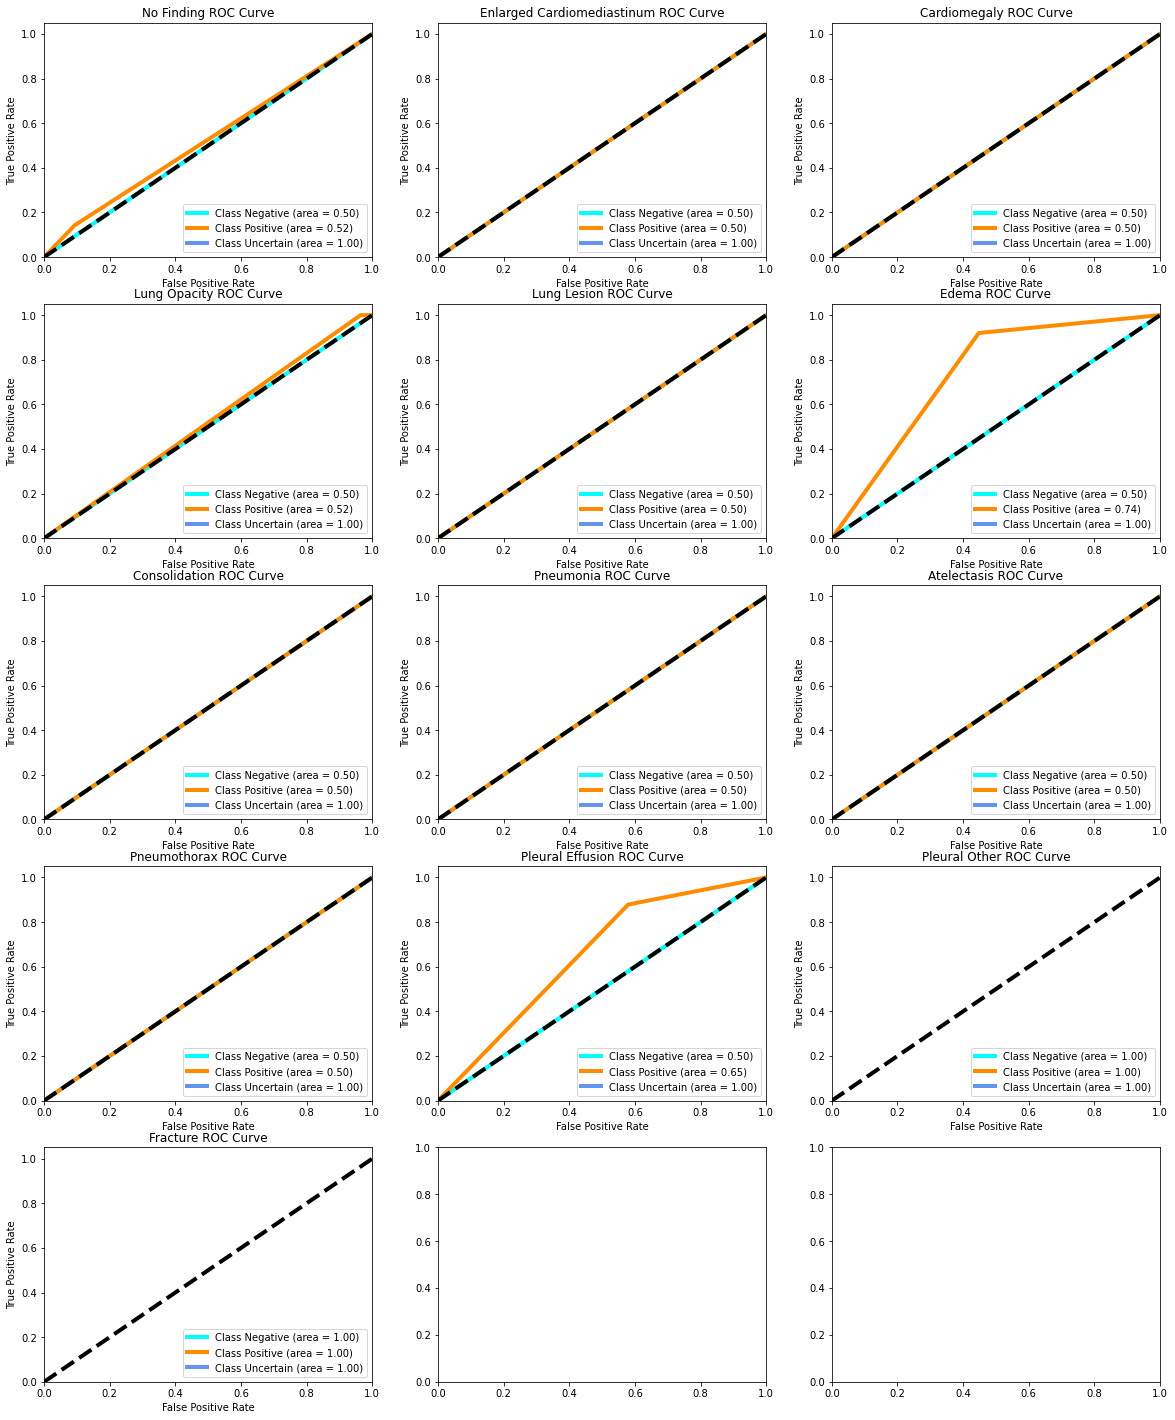

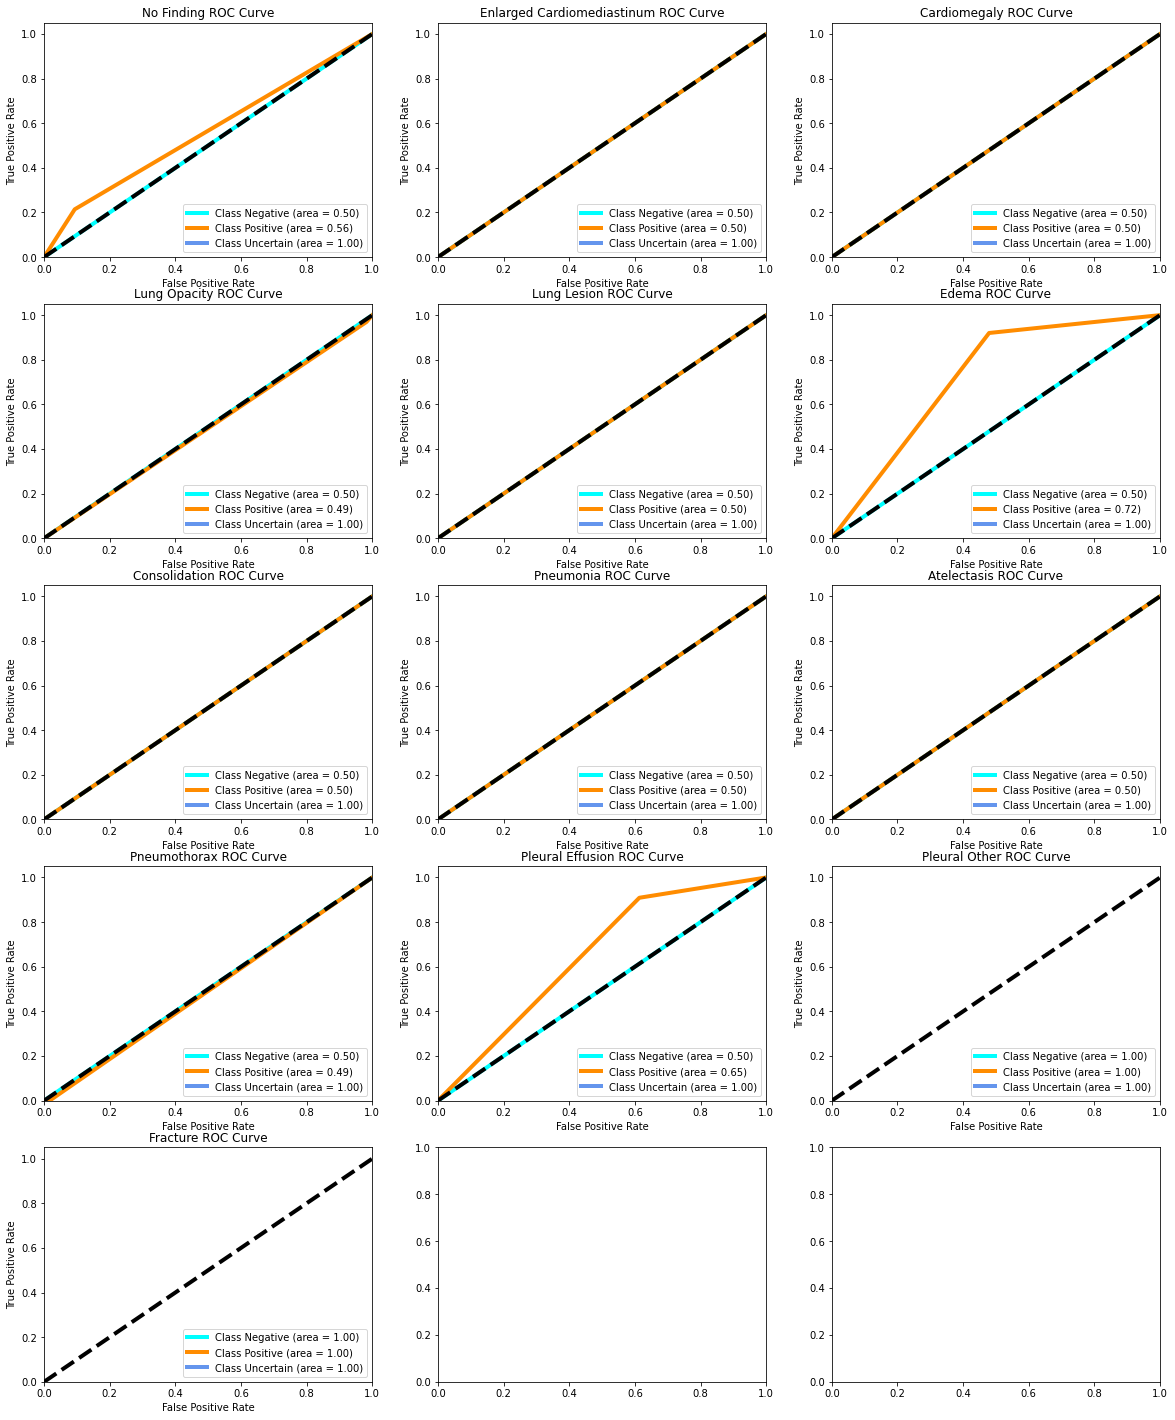

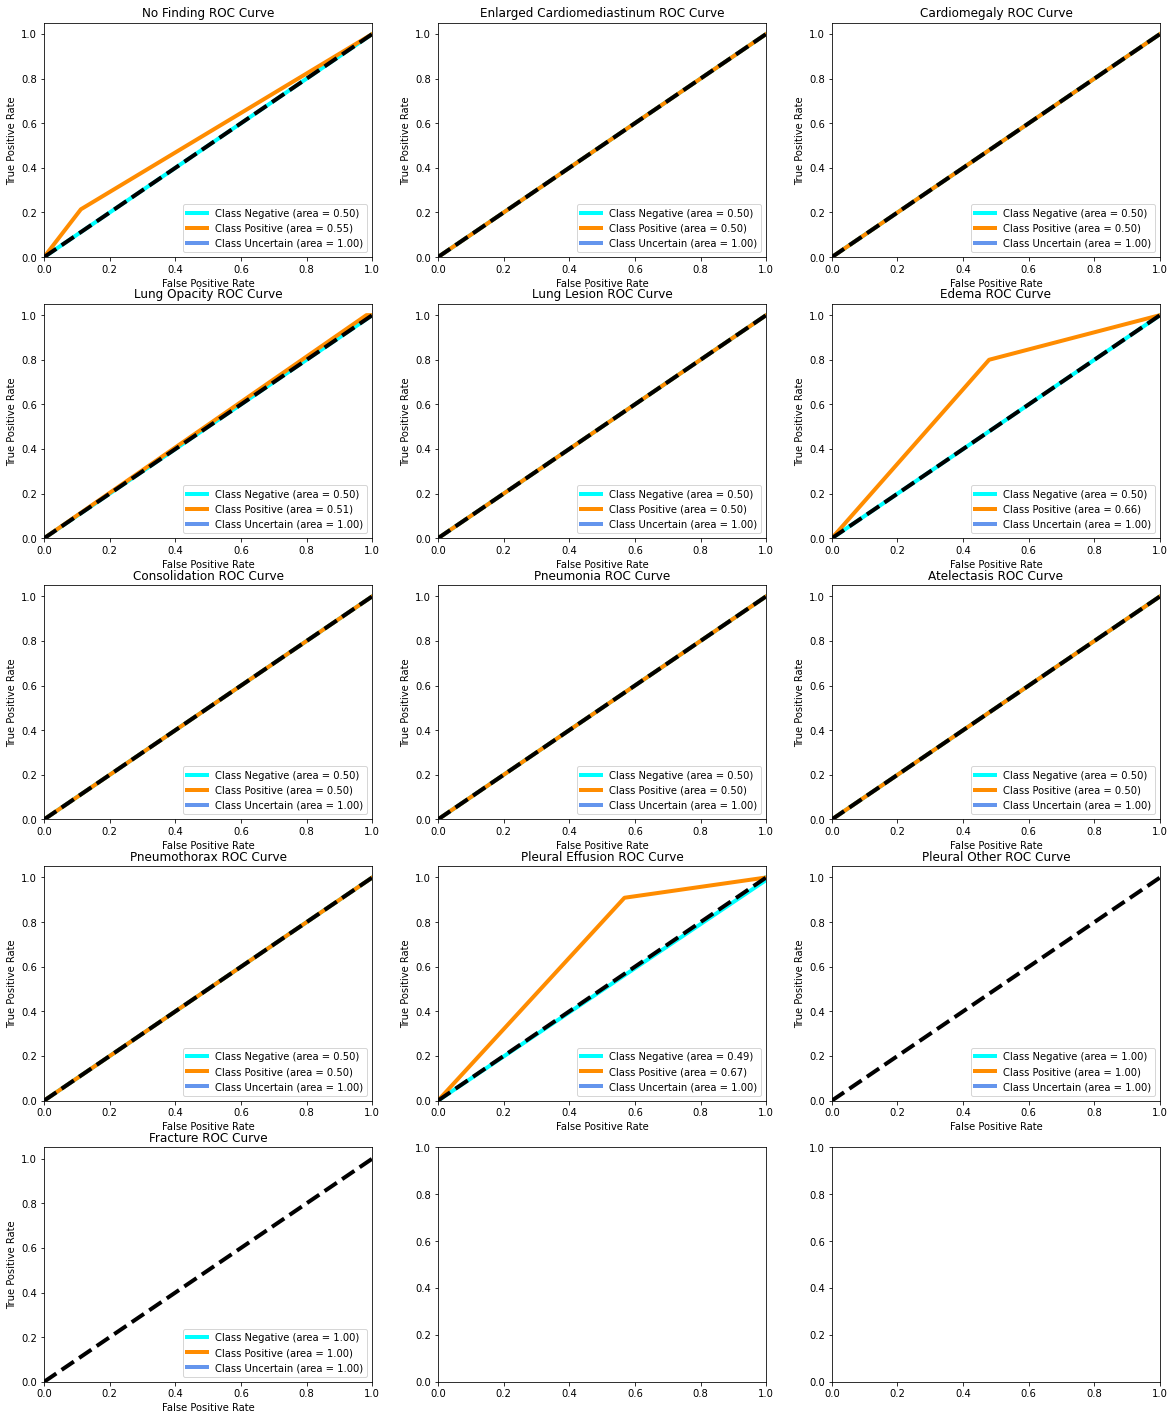

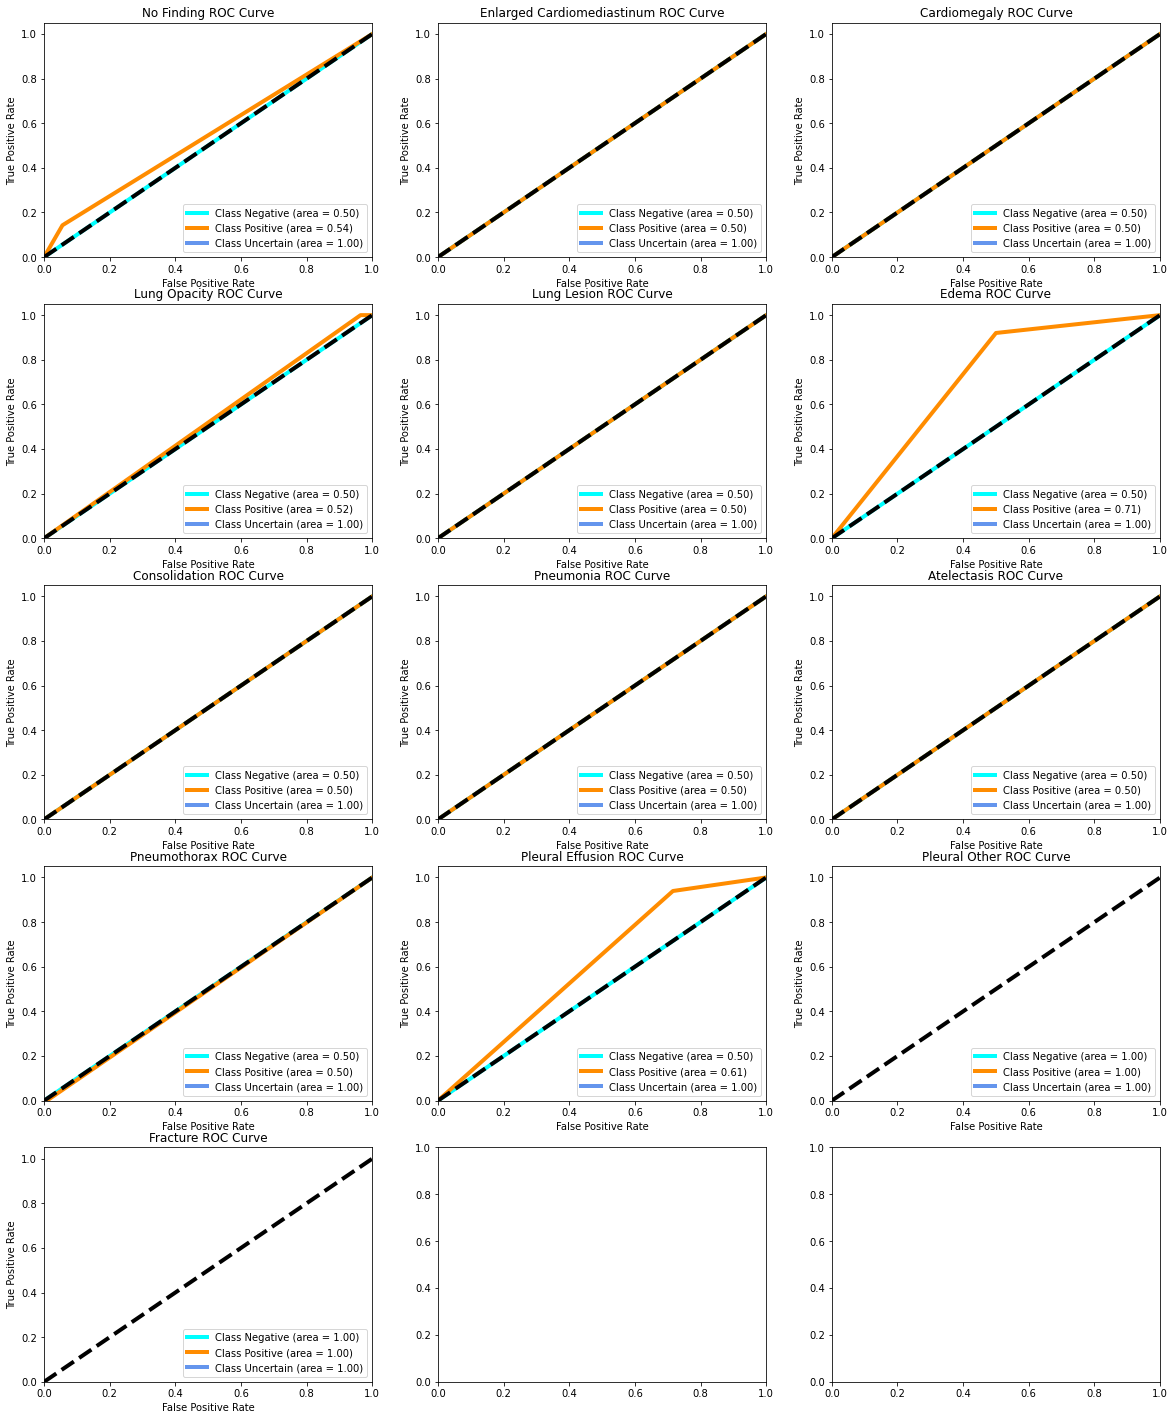

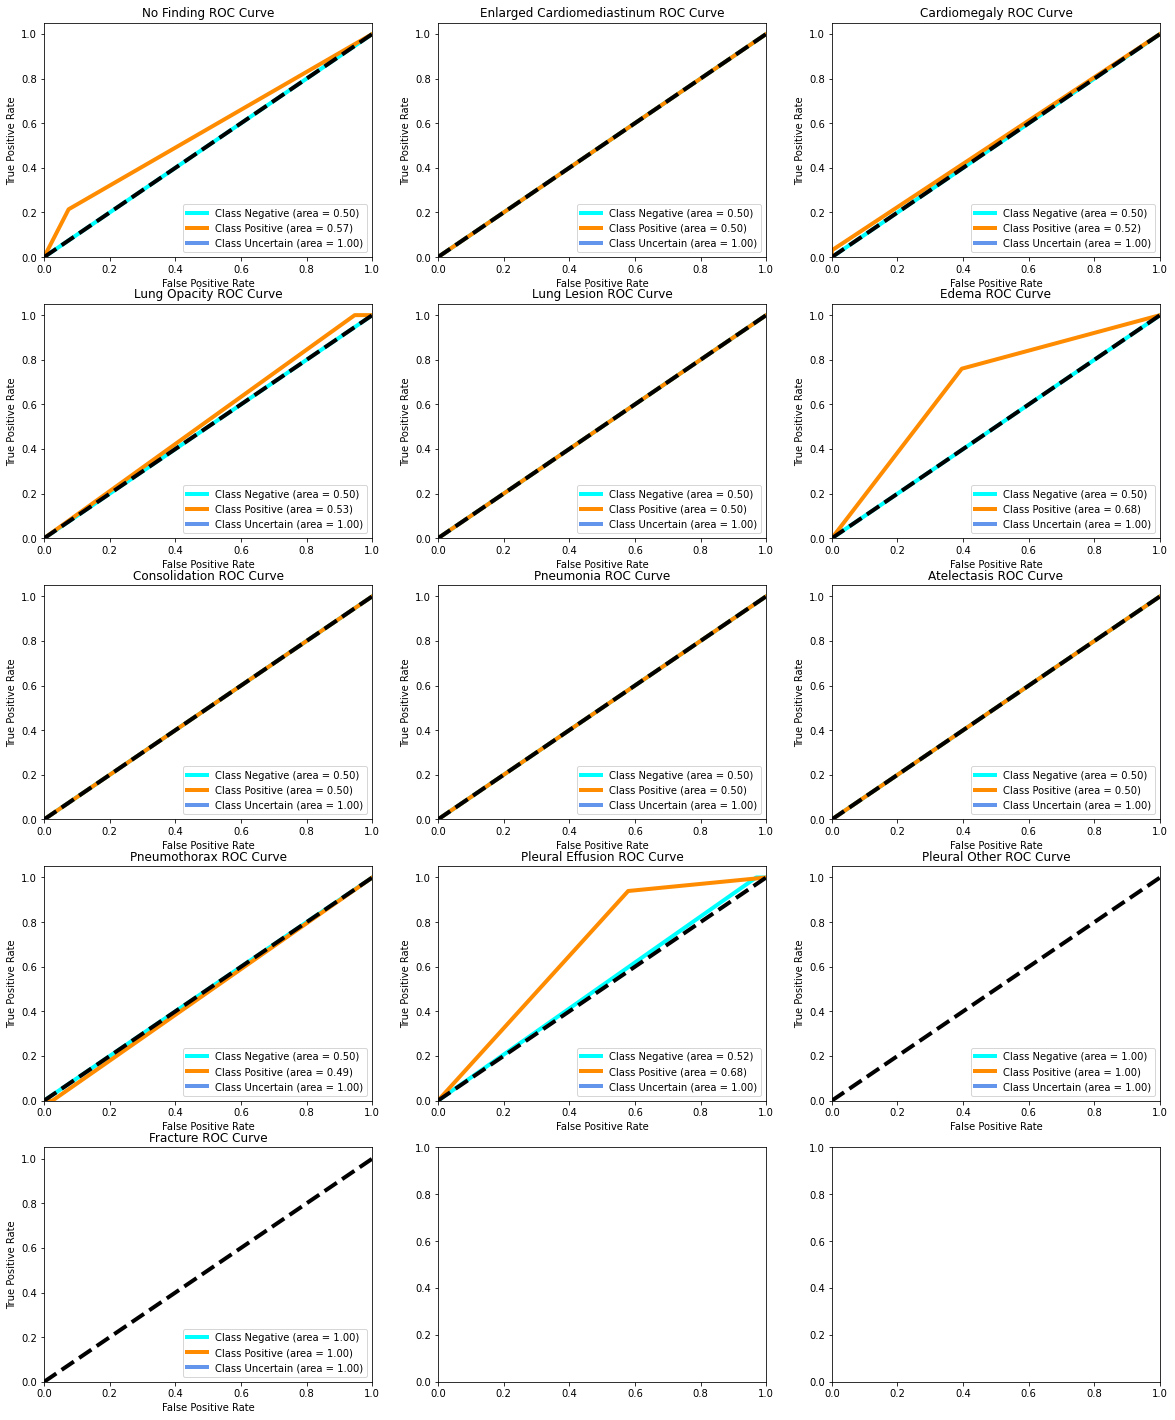

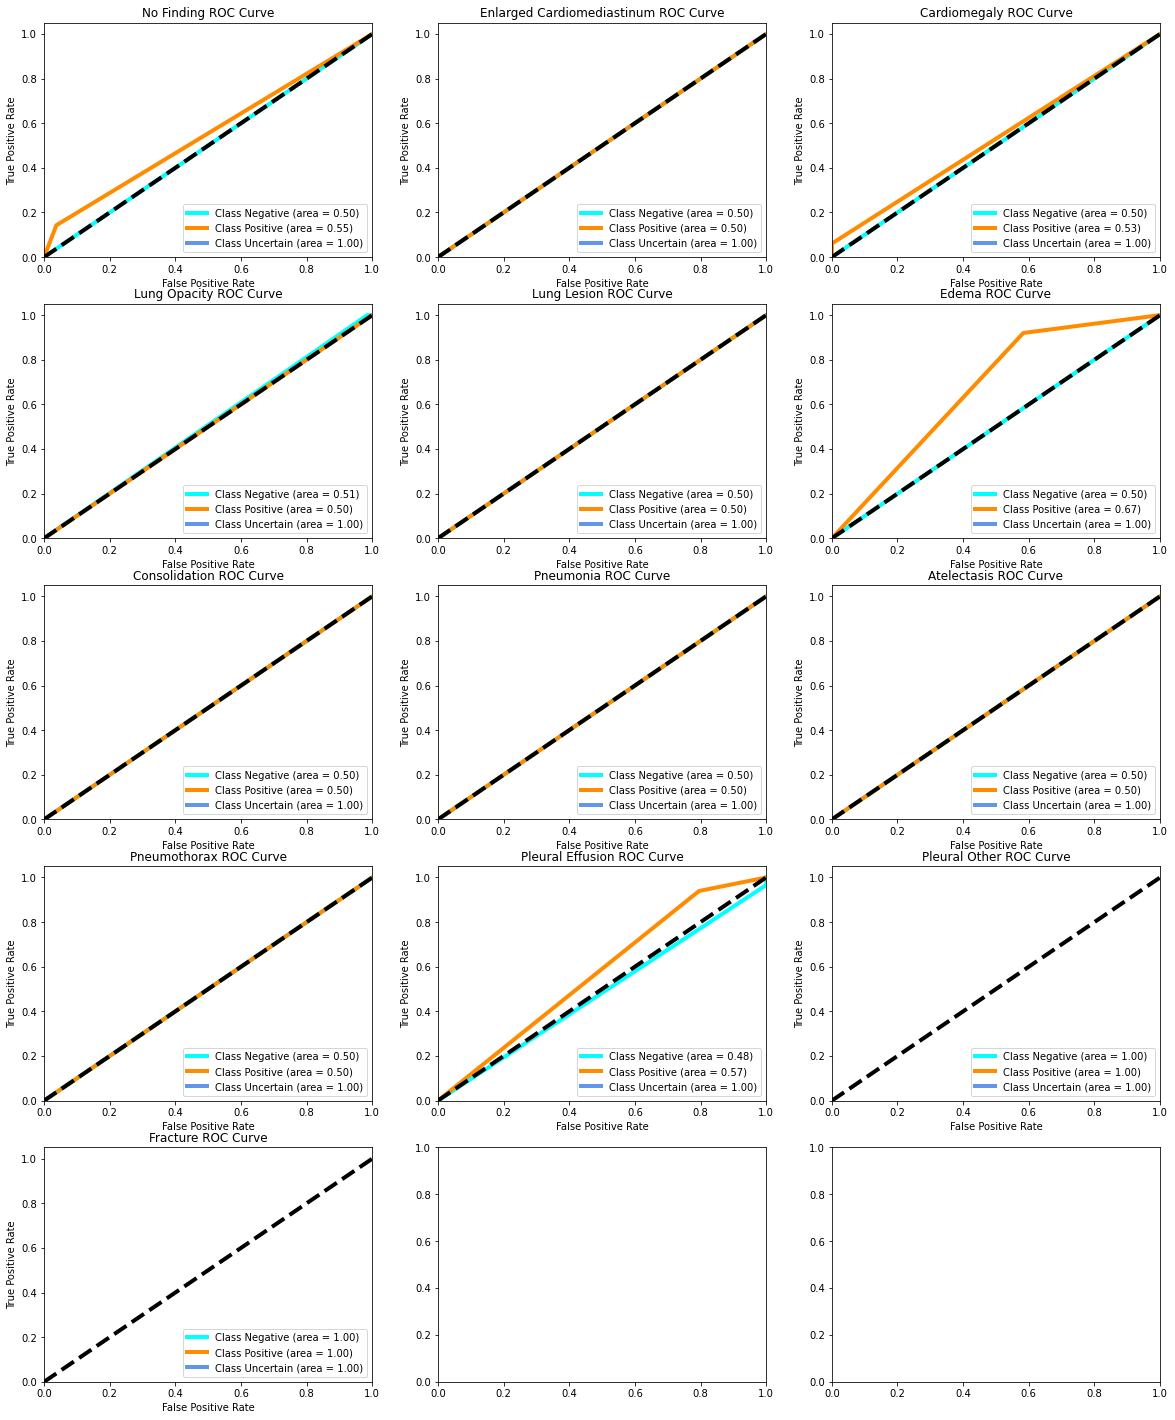

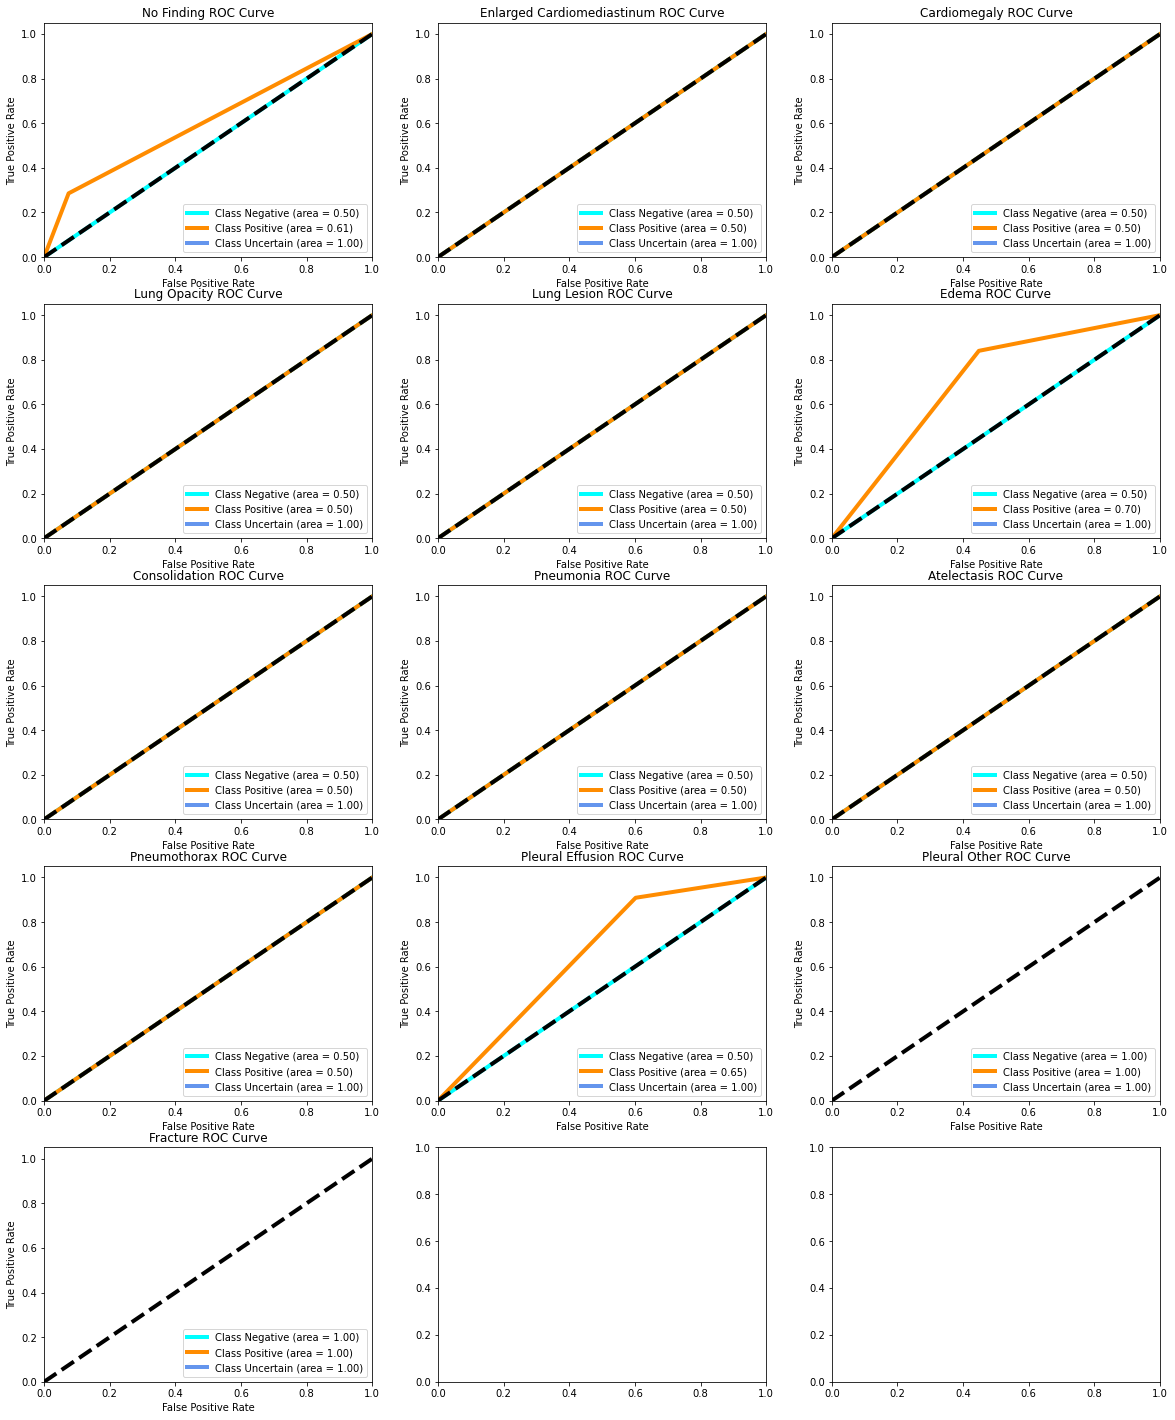

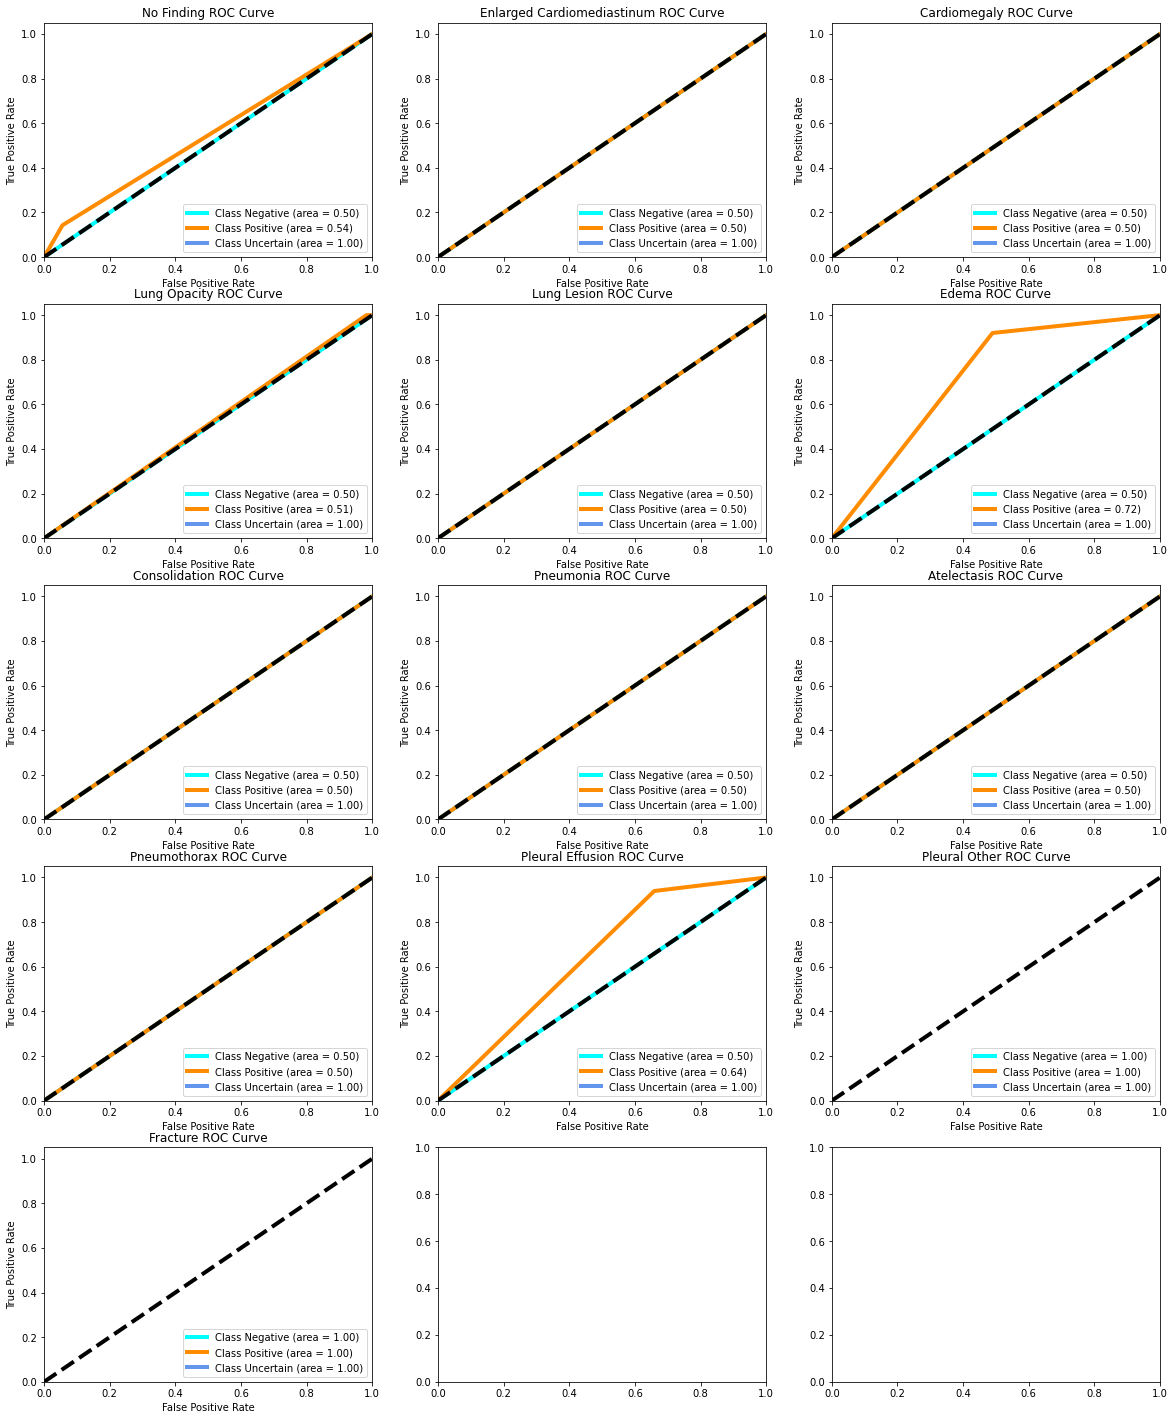

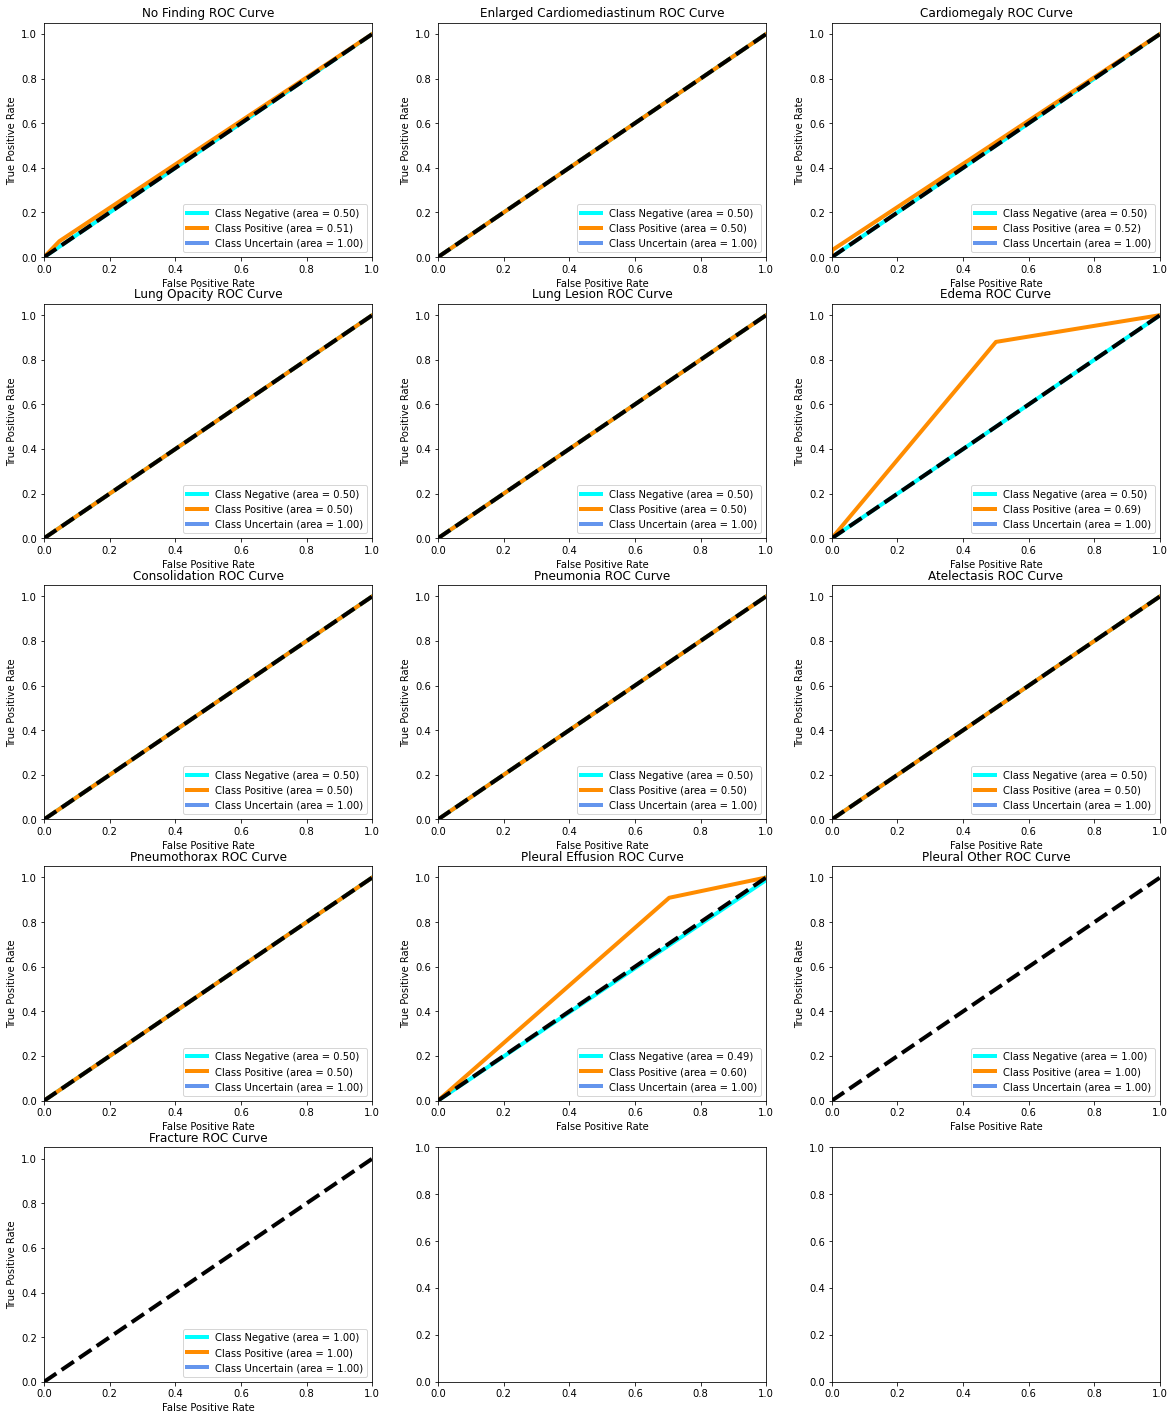

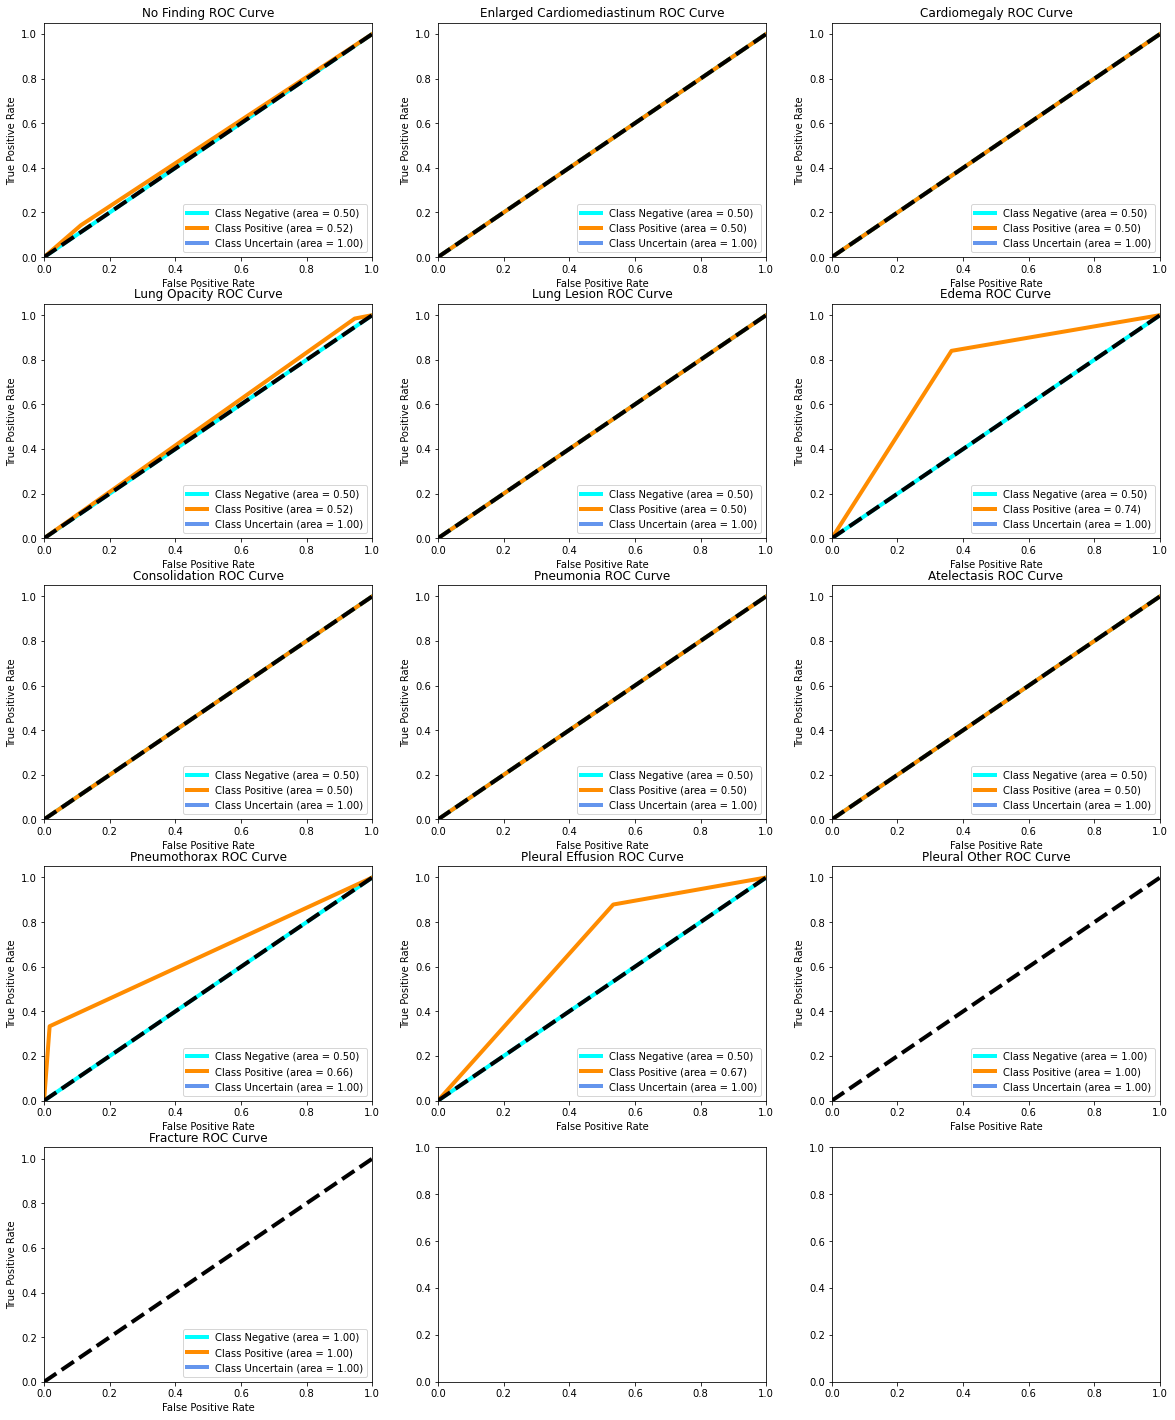

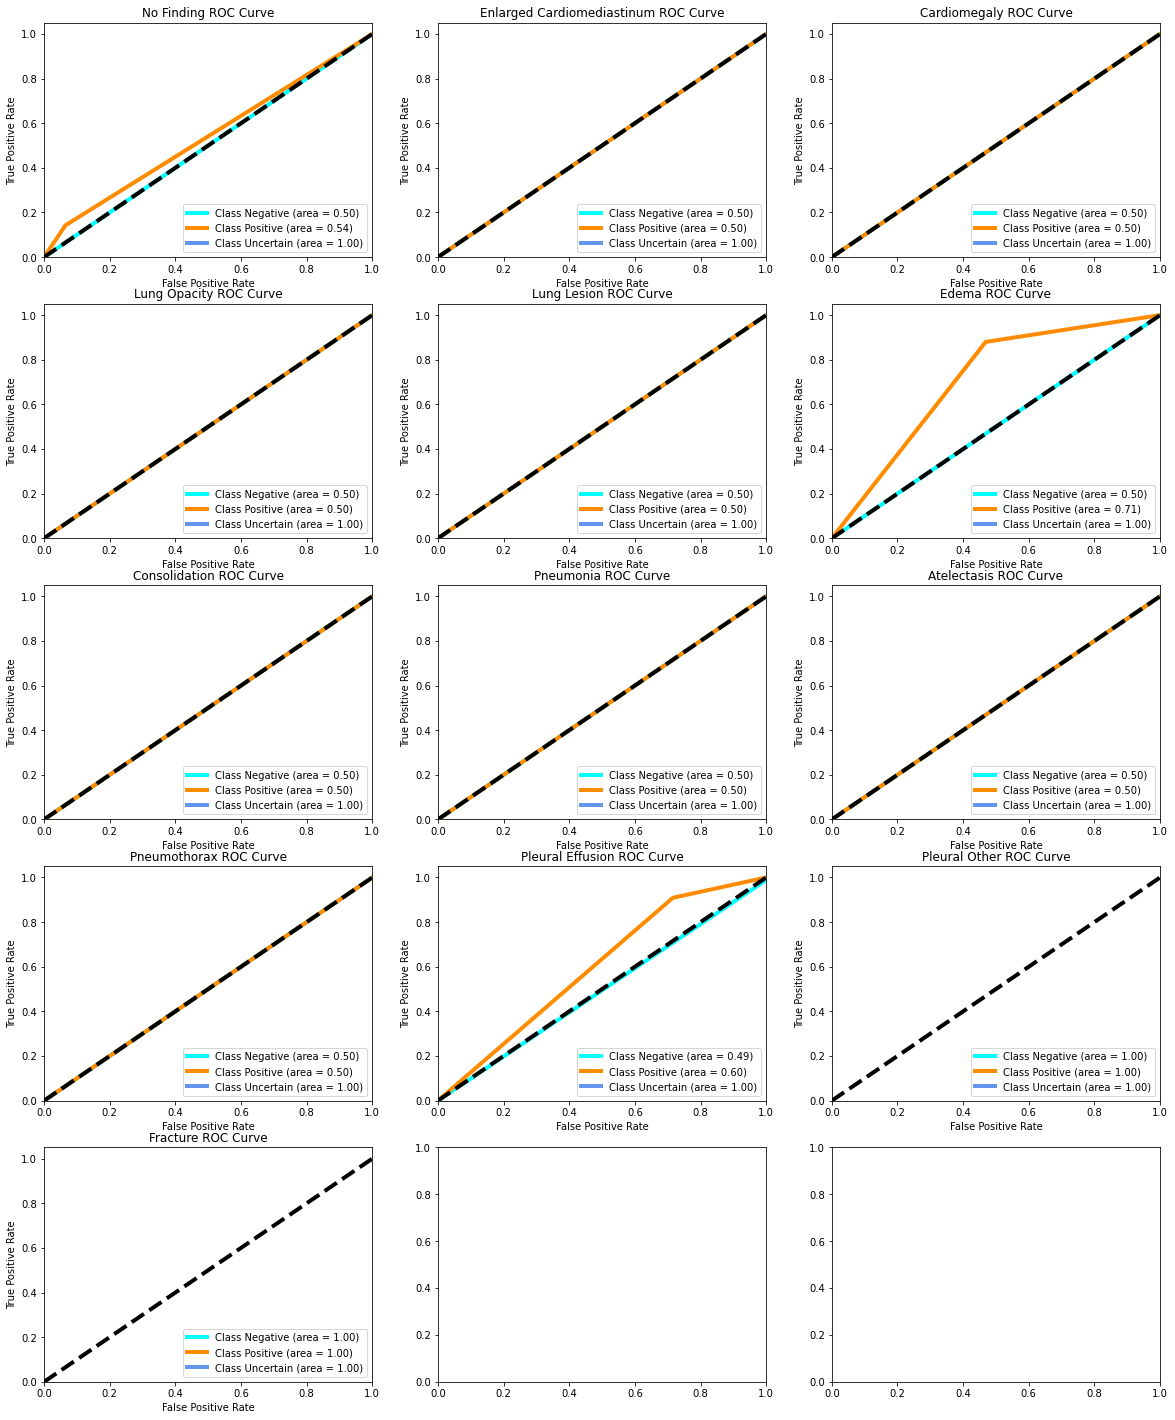

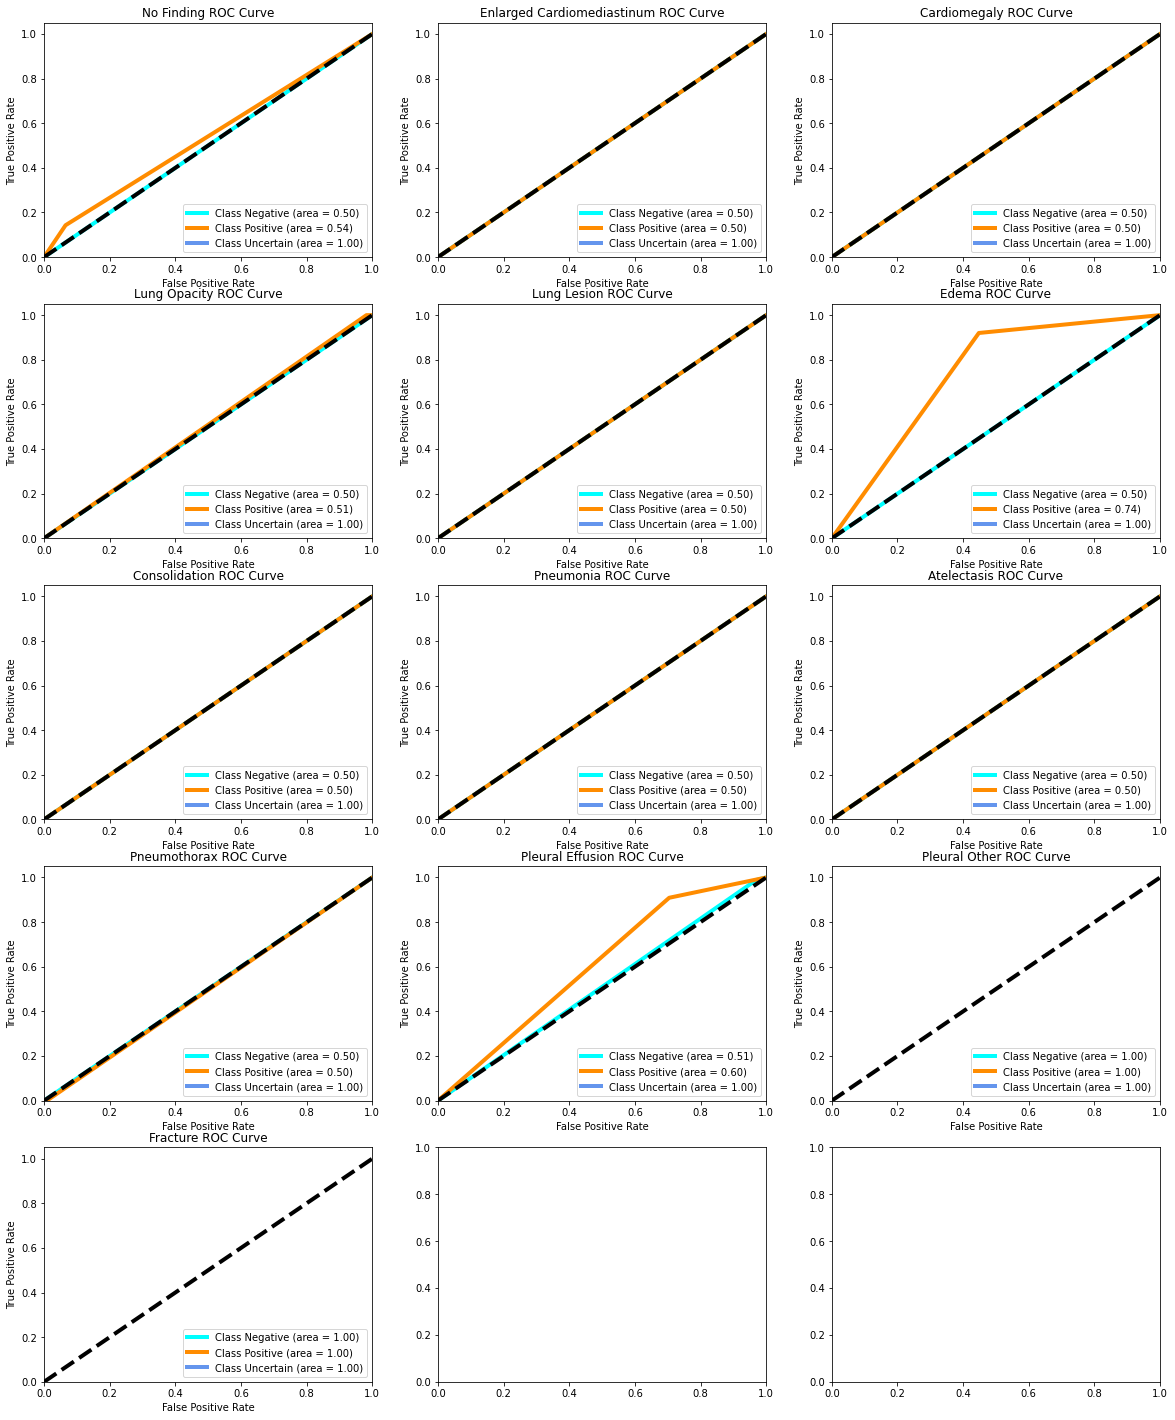

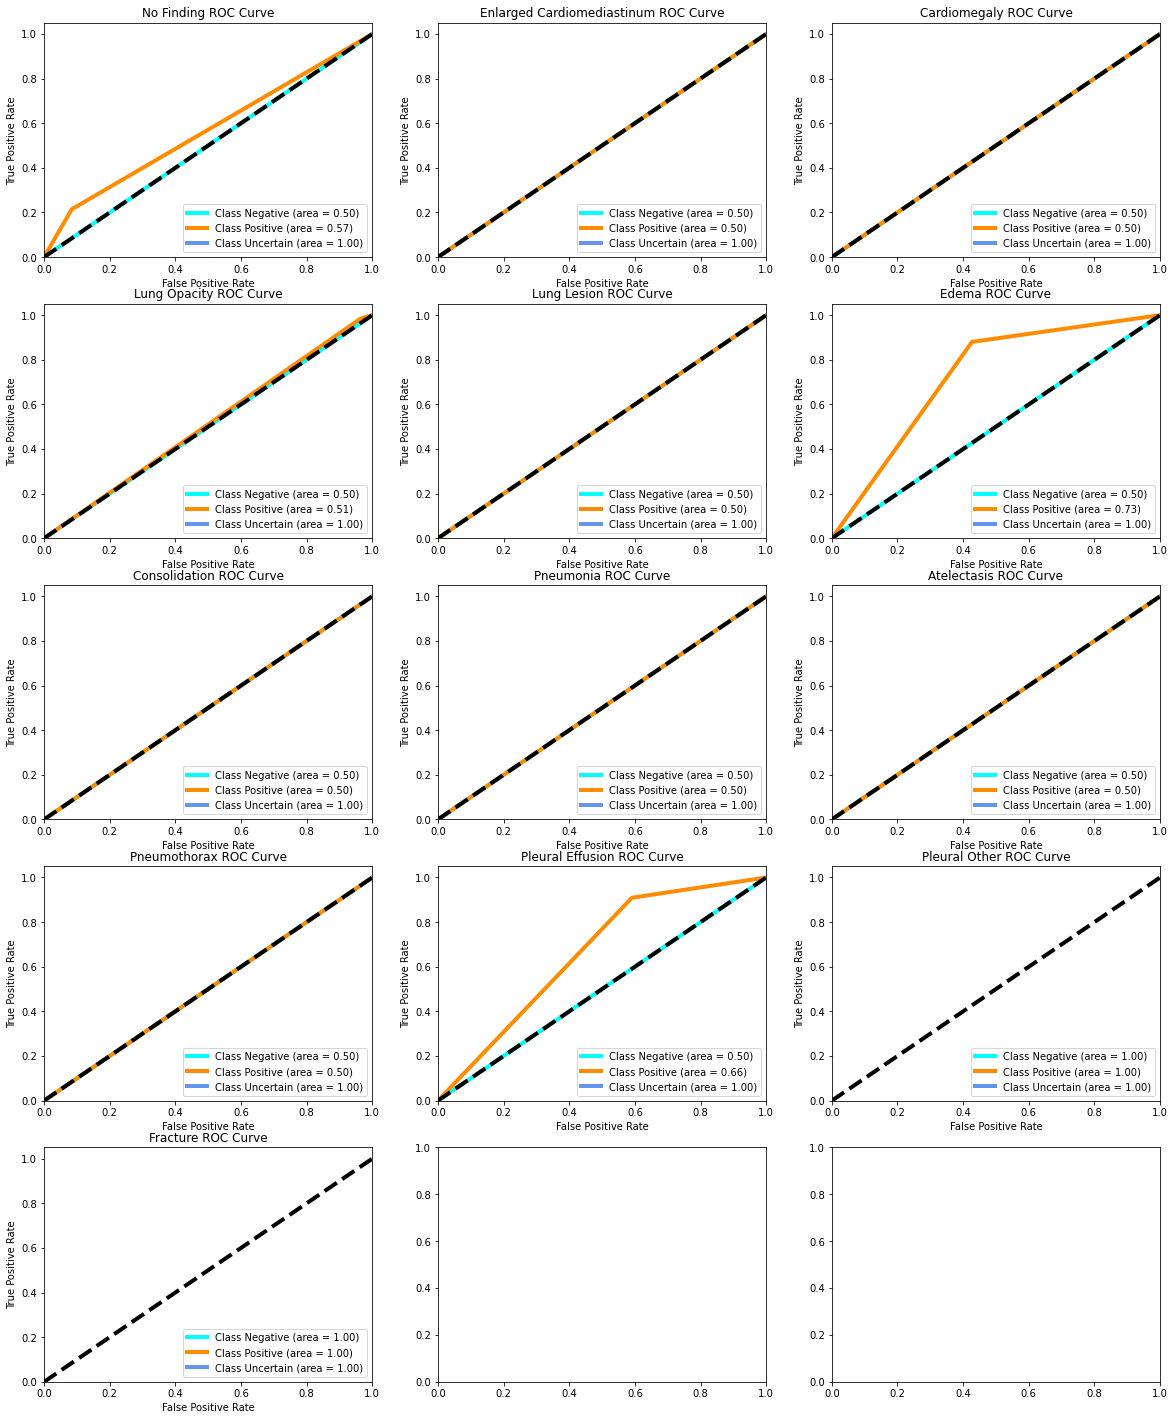

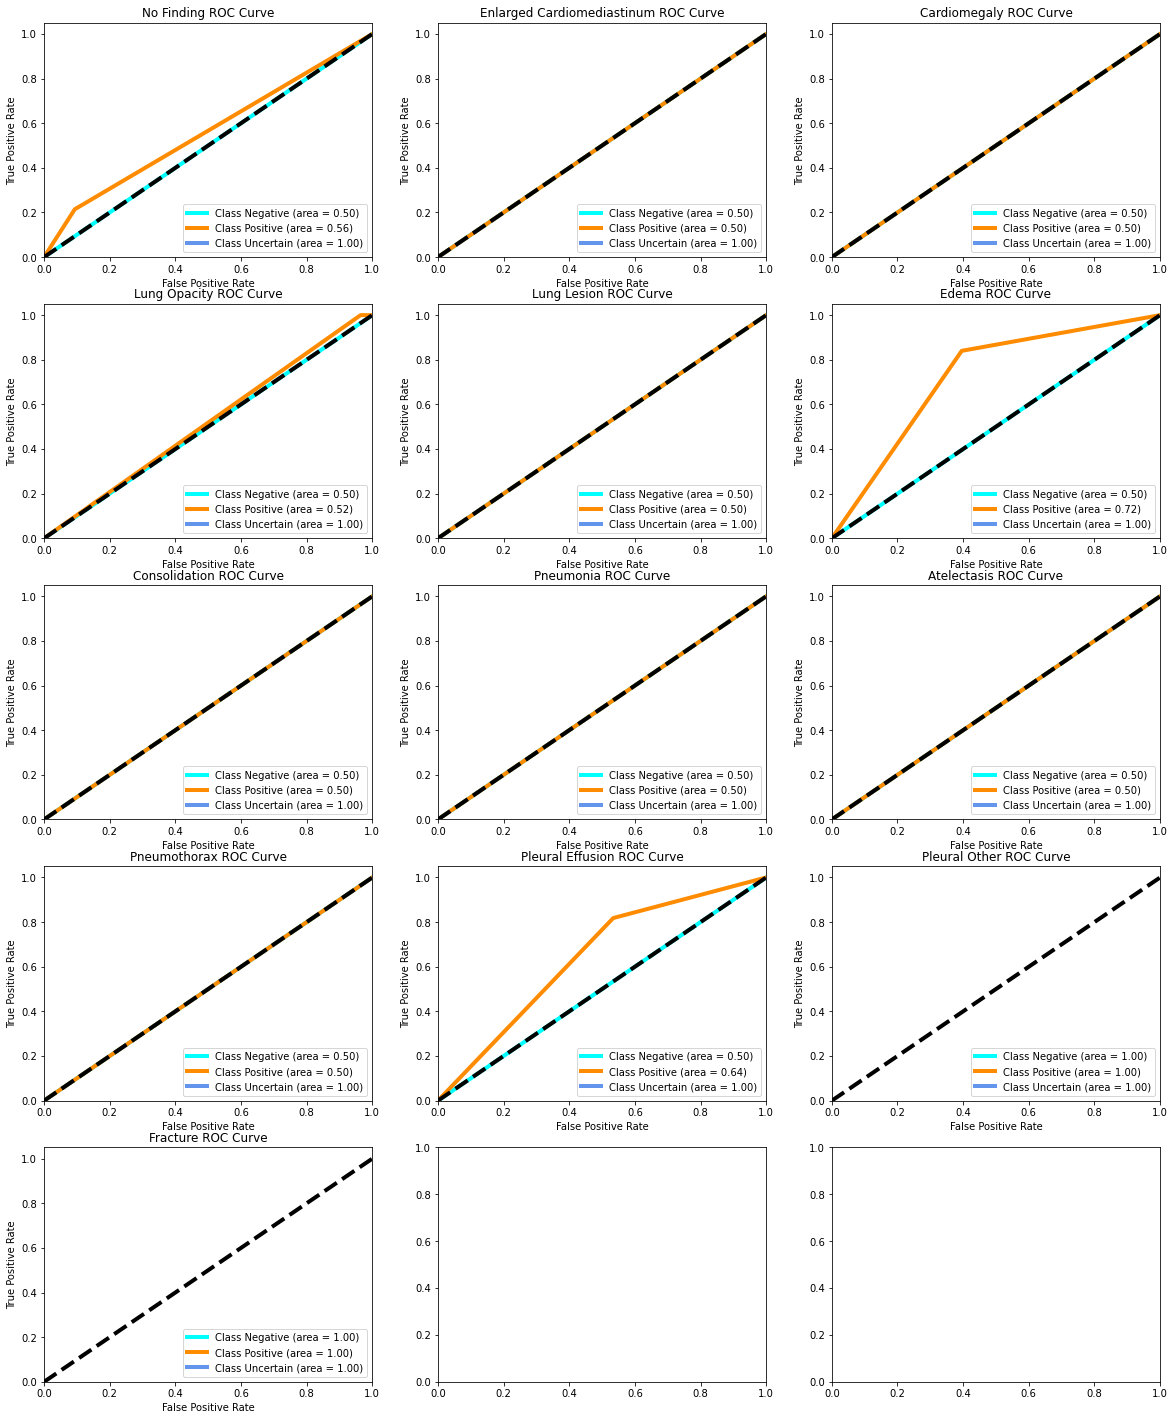

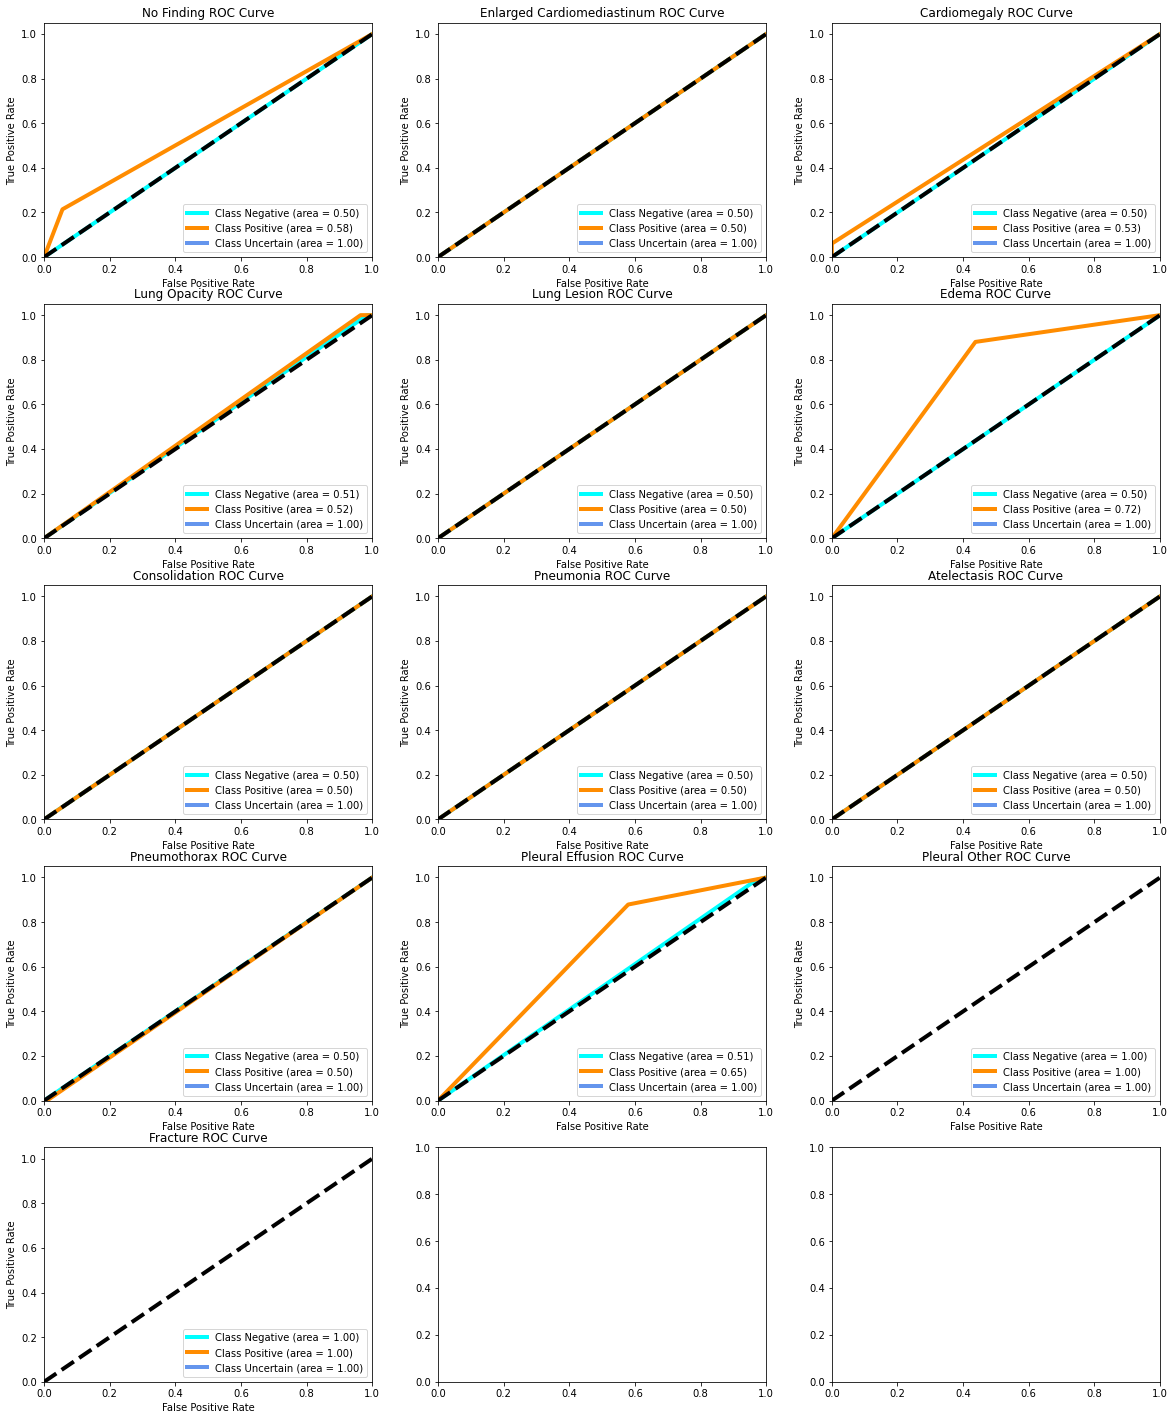

In [ ]:
from tqdm import tqdm
import pickle

n_every = 1500
n_val_every = 100
avg_loss_list = []


n_epochs_stop = 15
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf
iter = 0

neptune_num = '03'

#these will save the validation metric results for each epoch, Then can use them for plotting, analysis etc.
conf_mat_dict_list, fpr_list, tpr_list, roc_auc_list, accuracy_list, precision_list, recall_list, f1_list = [], [] ,[] ,[] ,[], [], [], []

for epoch in range(max_epochs):
    print('Epoch {}/{}'.format(epoch, max_epochs-1))
    # Training
    avg_loss = 0
    # Training

    for idx, (local_batch,local_labels) in enumerate(tqdm(training_generator, total=len(training_generator))):
        optimizer.zero_grad()
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = model(local_batch)

        
        loss = loss_fn(outputs, local_labels)

        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        
        if NEPTUNE_TRACK:
            neptune.log_metric('train_batch_loss', loss)
        
        if idx % n_every == 0:
            print('Batch Loss {}/{}: {:.3f}'.format(idx + 1, len(training_generator), loss))
    avg_loss /= len(training_generator)
    avg_loss_list.append(avg_loss)
    print('Train Loss: {:.3f}'.format(avg_loss))
    
    if NEPTUNE_TRACK:
        neptune.log_metric('train_loss', avg_loss)

    # Validation
    with torch.set_grad_enabled(False):
        avg_loss = 0
        accuracy = 0
        val_count = 0
        vec_loss_list = []
        pred_matrix = [] #use these to collect all the pred and gt for eval, after each epoch for now
        gt_matrix = []
        
        for idx, (data,local_labels) in enumerate(validation_generator):
            local_batch, ages, genders = data
            
#             # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            outputs = model(local_batch)
            loss = loss_fn(outputs, local_labels)
            avg_loss += loss.item()

            vec_loss = loss_fn(outputs, local_labels, mean=False)

            if idx % n_val_every == 0:
                print('validation batch Loss {}/{}: {:.3f}'.format(idx + 1, len(validation_generator), loss))
            
            if NEPTUNE_TRACK:
                neptune.log_metric('val_batch_loss', loss)
            
            
            avg_loss /= len(validation_generator)
            avg_loss_list.append(avg_loss)
            


            outputs = torch.sigmoid(outputs)

# take arg max of both the output matrix and ground truth reshaped matrix. 
            outputs = outputs.cpu().numpy()

            local_labels = local_labels.cpu().numpy()
            
            outputs_binary = np.select([outputs <= .5, outputs>.5], [np.zeros_like(outputs), np.ones_like(outputs)])
            
            #fix this or dont use it. its adding how many 0 and 1s match the GT
            accuracy += np.sum(outputs_binary == local_labels)
            val_count += len(validation_generator)+params['batch_size']+39
            pred_matrix.extend(outputs_binary)
            gt_matrix.extend(local_labels)
        
    print('Val Loss: {:.3f}'.format(avg_loss))

    accuracy /= len(validation_set)*39
    print(f"total count:{val_count}, size of matrix {len(pred_matrix)}x{len(pred_matrix[0])}")
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    #save metric dictionary of dictionaries for each epoch
    conf_mat_dict,fpr,tpr,roc_auc,accuracy,precision, recall, f1 = calc_val_metrics(gt_matrix, pred_matrix)
    
    conf_mat_dict_list.append(conf_mat_dict)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    accuracy_list.append(accuracy)
    precision_list.append(precision) 
    recall_list.append(recall) 
    f1_list.append(f1)
    
    if NEPTUNE_TRACK:
        neptune.log_metric('validation_loss', avg_loss)

                # If the validation loss is at a minimum
    if avg_loss < min_val_loss:
        save_checkpoint(avg_loss, min_val_loss, model, 'checkpoint_meta6.pt', True)
        epochs_no_improve = 0
        min_val_loss = avg_loss
        
        #save metrics for the checkpoint
        with open(f'val_metrics_c{neptune_num}_Train6.pkl', 'wb') as f:
            pickle.dump(conf_mat_dict_list,f)
            pickle.dump(fpr_list,f)
            pickle.dump(tpr_list,f)
            pickle.dump(roc_auc_list,f) 
            pickle.dump(accuracy_list,f)
            pickle.dump(precision_list,f)
            pickle.dump(recall_list,f)
            pickle.dump(f1_list,f)

    else:
        epochs_no_improve += 1
    iter += 1
    if epoch > 5 and epochs_no_improve == n_epochs_stop:
        print('Early stopping!' )
        early_stop = True
        break
    else:
        continue
            
    if early_stop:
        print("Stopped-saving model and metrics")
        break
        
#conf_mat_dict_list, fpr_list, tpr_list, roc_auc_list, accuracy_list saved as pickle files

PATH = f'hundred_epoch_chex-{neptune_num}.pth'
torch.save(model.state_dict(), 'state_dict_' + PATH)
torch.save(model, PATH)

with open(f'val_metrics_{neptune_num}.pkl', 'wb') as f:
        pickle.dump(conf_mat_dict_list,f)
        pickle.dump(fpr_list,f)
        pickle.dump(tpr_list,f)
        pickle.dump(roc_auc_list,f) 
        pickle.dump(accuracy_list,f)
        pickle.dump(precision_list,f)
        pickle.dump(recall_list,f)
        pickle.dump(f1_list,f)       